## This notebook is to preprocess multiple extracted datasets together.

In [1]:
#last update: 21-02-12 #used sort2

## 1. Import module, parameter file, and extracted file

### 1-01. Import modules, set path, select experiment (by stimulus)

In [2]:
MAC0_OR_LINUX1 = 1
SORT_VER = 'sort2'

In [3]:
#cd /Users/dlee/moving-bar

In [4]:
import sys
sys.path.append('../')

import numpy as np
import scipy.stats
import scipy.ndimage
import sklearn.linear_model
import json
import h5py
import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.patches
import pandas as pd
import sklearn.decomposition
import sklearn.cluster
import tqdm
import pickle

import pyret.stimulustools as st
import pyret.filtertools as ft
import pyret.spiketools as spk
import pyret.nonlinearities as nlt
import experiment as exp
import extract as ext
import utils
import stats
import analysis

%load_ext autoreload
%autoreload 2

In [5]:
utils.set_plot_params()

In [6]:
#mpl.rcParams['figure.figsize'] = [6.0, 4.0]
#mpl.rcParams['figure.dpi'] = 150
#mpl.rcParams['font.family'] = 'Arial'
#mpl.rcParams['font.size'] = 7

In [7]:
if MAC0_OR_LINUX1 == 1:
    home_dir = '/home'
elif MAC0_OR_LINUX1 == 0:
    home_dir = '/Users'
proj_dir = home_dir + '/dlee/moving-bar/'
exp_list = ['17-10-18', '17-10-20', '17-10-26', '17-10-26-1', '17-10-27',
            '17-11-06', '17-11-07', '17-11-08', '17-11-14', '17-11-14-1',
            '17-11-29', '18-03-12', '18-03-22', '18-03-23', '18-03-24',
            '18-03-24-1', '18-03-27', '18-04-23']
N_expt = len(exp_list)
stim_sort_total_list = ['flash_1', 'rf_wn', 'mb_ns', 'mb_ad', 'mb_da', 
                        'mb_2ad', 'mb_4ad', 'mb_2da', 'mb_4da', 'rf_30m']
stim_notforsort_total_list = ['line', 'rf_5m', 'mb', 'flash_2']
c_idx = utils.color_index()

In [8]:
SAVE_FOR_DEEP_RETINA_1 = 0
SAVE_FOR_DEEP_RETINA_2 = 0
SAVE_FOR_DEEP_RETINA_3 = 0
SAVE_FOR_DEEP_RETINA_4 = 0

### 1-02. Make a experiment.Experiment Class

In [9]:
ex = exp.Experiment(name='mb', 
                    stimlist=['flash_1', 'rf_wn', 'mb_ns', 'mb_ad', 'mb_da', 
                              'mb_2ad', 'mb_4ad', 'mb_2da', 'mb_4da', 'rf_30m', 
                              'line', 'rf_5m', 'mb', 'flash_2', 
                              'mb_ad_ao'],
                    rflist=['st', 'line', 'space', 'time', 'ellipse'])

### 1-03. Load .json file and make an pandas.DataFrame to efficiently analyze data & Load .h5 file

In [10]:
df = pd.DataFrame()
for e in range(N_expt):
    # load .json file
    with open(proj_dir + 'json/' + SORT_VER + '/' + exp_list[e] + '.json', 'r') as js:
        p = json.load(js)
    df = pd.concat([df, pd.DataFrame(data=p)], ignore_index=True)

    # load ##-##-##-extract.h5 file
    with h5py.File(proj_dir + 'data-extract/' + SORT_VER + '/' + exp_list[e] + '_extract.h5', 'r') as f:
        # ganglion
        for g in range(p['g_cell_num']):
            g_temp_sort = {k: v for (k, v) in 
                           zip(list(l for l in stim_sort_total_list if not f['sort'][l]['ganglion'].shape == ()),
                               list(f['sort'][s]['ganglion'][g] for s in stim_sort_total_list          #uint8
                                    if not f['sort'][s]['ganglion'].shape == ()))}
            g_temp_rf = {'st': np.double(f['rf/ganglion/st'][g]),
                         'space': np.double(f['rf/ganglion/space'][g]),
                         'time': np.double(f['rf/ganglion/time'][g]),
                         'ellipse': np.double(f['rf/ganglion/ellipse'][g])}                            # sigma=1
            ex.addcelldata(g_temp_sort, mode='ganglion')
            ex.addcelldata(g_temp_rf, mode='grf')
            
        # intracell   
        i_temp_sort = {k: v for (k, v) in 
                       zip(list(l for l in stim_sort_total_list if not f['sort'][l]['intracell'].shape == ()),
                           list(np.double(f['sort'][s]['intracell']) for s in stim_sort_total_list
                                if not f['sort'][s]['intracell'].shape == ()))}
        i_temp_unsort = {k: v for (k, v) in 
                         zip(list(l for l in stim_notforsort_total_list if not f['unsort'][l]['intracell'].shape == ()),
                             list(np.double(f['unsort'][s]['intracell']) for s in stim_notforsort_total_list
                                  if not f['unsort'][s]['intracell'].shape == ()))}
        if not f['etc/mb_ad_ao/intracell'].shape == ():
            i_temp_etc = {'mb_ad_ao': np.double(f['etc/mb_ad_ao/intracell'])} 
        else:
            i_temp_etc = {}
        i_temp_rf = {'st': np.double(f['rf/intracell/st']),
                     'line': np.double(f['rf/intracell/line']),
                     'space': np.double(f['rf/intracell/space']),
                     'time': np.double(f['rf/intracell/time']),
                     'ellipse': np.double(f['rf/intracell/ellipse'])}                                  #sigma=1
        ex.addcelldata({**i_temp_sort, **i_temp_unsort, **i_temp_etc}, mode='intracell')
        ex.addcelldata(i_temp_rf, mode='irf')
        
        # stim
        stim_temp_sort = {k: v for (k, v) in 
                          zip(list(l for l in stim_sort_total_list if not f['sort'][l]['stim'].shape == ()),
                              list(np.uint8(((np.double(f['sort'][s]['stim'])/2)+0.5)*255) for s in stim_sort_total_list          #uint8 (flash_1 is from 0/255)
                                   if not f['sort'][s]['stim'].shape == ()))}
        stim_temp_unsort = {k: v for (k, v) in 
                            zip(list(l for l in stim_notforsort_total_list if not f['unsort'][l]['stim'].shape == ()),
                                list(np.uint8(((np.double(f['unsort'][s]['stim'])/2)+0.5)*255) for s in stim_notforsort_total_list         #uint8 (flash_2 is from 0/255)
                                     if not f['unsort'][s]['stim'].shape == ()))}
        if not f['etc/mb_ad_ao/stim'].shape == ():
            stim_temp_etc = {'mb_ad_ao': np.double(f['etc/mb_ad_ao/stim'])} 
        else:
            stim_temp_etc = {}
        ex.addcelldata({**stim_temp_sort, **stim_temp_unsort, **stim_temp_etc}, mode='stim')

        # tbins
        tbins_temp_sort = {k: v for (k, v) in 
                           zip(list(l for l in stim_sort_total_list if not f['sort'][l]['tbins'].shape == ()),
                               list(np.double(f['sort'][s]['tbins']) for s in stim_sort_total_list
                                    if not f['sort'][s]['tbins'].shape == ()))}
        tbins_temp_unsort = {k: v for (k, v) in 
                            zip(list(l for l in stim_notforsort_total_list if not f['unsort'][l]['tbins'].shape == ()),
                                list(np.double(f['unsort'][s]['tbins']) for s in stim_notforsort_total_list
                                     if not f['unsort'][s]['tbins'].shape == ()))}
        if not f['etc/mb_ad_ao/tbins'].shape == ():
            tbins_temp_etc = {'mb_ad_ao': np.double(f['etc/mb_ad_ao/tbins'])} 
        else:
            tbins_temp_etc = {}
        ex.addcelldata({**tbins_temp_sort, **tbins_temp_unsort, **tbins_temp_etc}, mode='tbins')

In [11]:
df.head()

,exp_id,exp_date,exp_name,exp_version,sort_version_num,retina_idx,intracell_idx,g_cell_num,g_cell_id,flash_1,...,mb_2ad_th,mb_4ad_th,mb_2da_th,mb_4da_th,rf_30m_th,line_w4_th,line_w8_th,rf_5m_th,mb_th,flash_2_th
0,0,17-10-18,17-10-18,1,2,1,5,6,0,1,...,0.5,-1.0,0.5,-1.0,0.5,0.5,-1.0,0.5,0.5,0.5
1,0,17-10-18,17-10-18,1,2,1,5,6,1,1,...,0.5,-1.0,0.5,-1.0,0.5,0.5,-1.0,0.5,0.5,0.5
2,0,17-10-18,17-10-18,1,2,1,5,6,2,1,...,0.5,-1.0,0.5,-1.0,0.5,0.5,-1.0,0.5,0.5,0.5
3,0,17-10-18,17-10-18,1,2,1,5,6,3,1,...,0.5,-1.0,0.5,-1.0,0.5,0.5,-1.0,0.5,0.5,0.5
4,0,17-10-18,17-10-18,1,2,1,5,6,4,1,...,0.5,-1.0,0.5,-1.0,0.5,0.5,-1.0,0.5,0.5,0.5


In [12]:
N_g = df.shape[0]
N_i = df['exp_id'].max() + 1
N_g, N_i

(189, 18)

### 1-04. (Optional) Saves stimulus and data for CNN models (rf_30m all)

In [13]:
if SAVE_FOR_DEEP_RETINA_1:
    with h5py.File(proj_dir + 'data-deepretina/17-10-18_et_al_rf_30m.h5', 'w') as f:
        f.create_dataset('data/rf_30m/ganglion', data=np.stack([ex.g['rf_30m'][g][:] for g in range(N_g)]))
        f.create_dataset('data/rf_30m/stim', data=ex.stim['rf_30m'][0].astype(int), dtype='i')
        f.create_dataset('data/rf_30m/tbins', data=ex.tbins['rf_30m'][0])

        #for i in range(N_i):
        #    f.create_dataset('data/rf_5m/' + str(i) + '/intracell', data=ex.i['rf_5m'][i])
        #    f.create_dataset('data/rf_5m/' + str(i) + '/stim', data=ex.stim['rf_5m'][i])
        #    f.create_dataset('data/rf_5m/' + str(i) + '/tbins', data=ex.tbins['rf_5m'][i])

### 1-05. (Optional) Saves stimulus and data for CNN models (rf_5m, some)

In [14]:
#for i in [0, 1, 2, 3, 4, 5, 6, 9, 11, 12, 13, 14, 15, 16]:
#    print(ex.stim['rf_5m'][i].shape)

In [15]:
# 120 Hz
rf_5m_list = [0, 1, 2, 3, 4, 5, 6, 9, 11, 12, 13, 14, 15, 16]
if SAVE_FOR_DEEP_RETINA_2:
    with h5py.File(proj_dir + 'data-deepretina/17-10-18_et_al_rf_5m.h5', 'w') as f:
        f.create_dataset('response', data=np.stack([(ex.i['rf_5m'][i][-32900:] - np.mean(ex.i['rf_5m'][i][-32900:]))/np.std(ex.i['rf_5m'][i][-32900:]) for i in rf_5m_list]))
        f.create_dataset('stimulus', data=ex.stim['rf_5m'][0][-32900:, :, :].astype(int), dtype='i')
        f.create_dataset('time', data=ex.tbins['rf_5m'][0][-32900:] - ex.tbins['rf_5m'][0][-32900])

In [16]:
# 100 Hz (transform; 32880 to 27400)
if SAVE_FOR_DEEP_RETINA_3:
    with h5py.File(proj_dir + 'data-deepretina/17-10-18_et_al_rf_5m_100Hz.h5', 'w') as f:
        f.create_dataset('response', data=np.stack([
            scipy.signal.resample((ex.i['rf_5m'][i][-32880:] - np.mean(ex.i['rf_5m'][i][-32880:]))/np.std(ex.i['rf_5m'][i][-32880:]), 27400) for i in rf_5m_list]))
        
        stim_100Hz_temp_3 = np.zeros((27400, 32, 32))
        stim_us_temp_3 = st.upsample(ex.stim['rf_5m'][0][-32880:, :, :], 5)[0]
        for i in range(27400):
            stim_100Hz_temp_3[i, :, :] = np.mean(stim_us_temp_3[6*i:6*(i+1), :, :], 0)
        f.create_dataset('stimulus', data=stim_100Hz_temp_3.repeat(2, 1).repeat(2, 2))
        
        f.create_dataset('time', data=np.arange(0, (ex.tbins['rf_5m'][0][-32880:] - ex.tbins['rf_5m'][0][-32880])[-1], 
                                                (ex.tbins['rf_5m'][0][-32880:] - ex.tbins['rf_5m'][0][-32880])[1] * 120/100))

### 1-06. (Optional) Saves stimulus and data for CNN models (line_w4, some)

In [17]:
# 100 Hz (transform; 12960 to 10800)
line_w4_list = [0, 1, 2, 3, 4, 5, 6, 9, 11, 12, 13, 14, 15, 16]
line_w4_list_idx1 = [int(2000 - df[df['exp_id'] == i]['idx1_line_w4'].mean()) for i in line_w4_list]
line_w4_list_idx2 = [int(-1040 - df[df['exp_id'] == i]['idx2_line_w4'].mean()) for i in line_w4_list]
line_w4_list_zip = zip(line_w4_list, line_w4_list_idx1, line_w4_list_idx2)
if SAVE_FOR_DEEP_RETINA_4:
    with h5py.File(proj_dir + 'data-deepretina/17-10-18_et_al_line_w4_100Hz.h5', 'w') as f:
        f.create_dataset('response', data=np.stack([
            scipy.signal.resample((ex.i['line'][i][j:k] - np.mean(ex.i['line'][i][j:k]))/np.std(ex.i['line'][i][j:k]), 10800) for i, j, k in line_w4_list_zip]))
        
        stim_100Hz_temp_4 = np.zeros((10800, 64, 64))
        stim_us_temp_4 = st.upsample(ex.stim['line'][0][line_w4_list_idx1[0]:line_w4_list_idx2[0]], 5)[0]
        for i in range(10800):
            for j in range(64):
                stim_100Hz_temp_4[i, j, :] = np.mean(stim_us_temp_4[6*i:6*(i+1), :], 0)
        f.create_dataset('stimulus', data=stim_100Hz_temp_4)
        f.create_dataset('time', data=np.arange(0, (ex.tbins['line'][0][line_w4_list_idx1[0]:] - ex.tbins['line'][0][line_w4_list_idx1[0]])[-1], 
                                                (ex.tbins['line'][0][line_w4_list_idx1[0]:] - ex.tbins['line'][0][line_w4_list_idx1[0]])[1] * 120/100))

## 2. Inspect loaded dataset and classify functional types of recorded cells

### 2-01. Check receptive fields

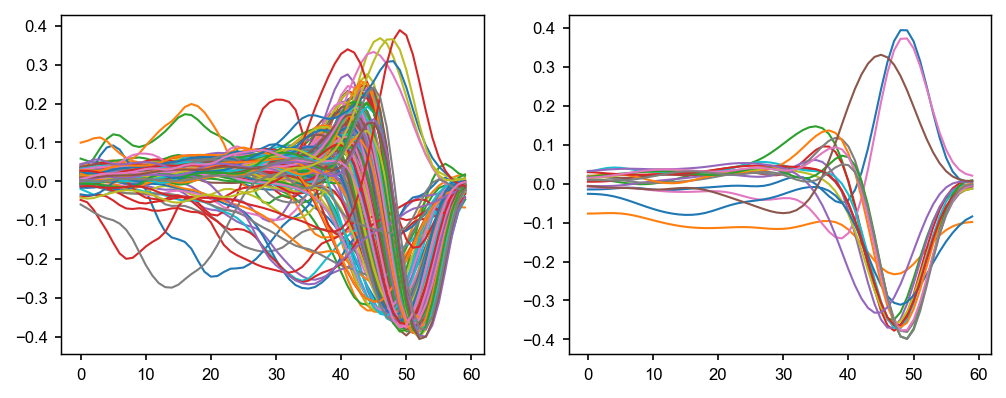

In [18]:
fig = plt.figure(figsize=(8, 3))
ax = plt.subplot(1, 2, 1)
for i in range(N_g):
    ax.plot(ex.rf['g']['time'][i])
ax = plt.subplot(1, 2, 2)    
for i in range(N_i):
    ax.plot(ex.rf['i']['time'][i])

Caution!!!!!!!!!!!!!!! These images were rotated to match with ellipse, so be careful!


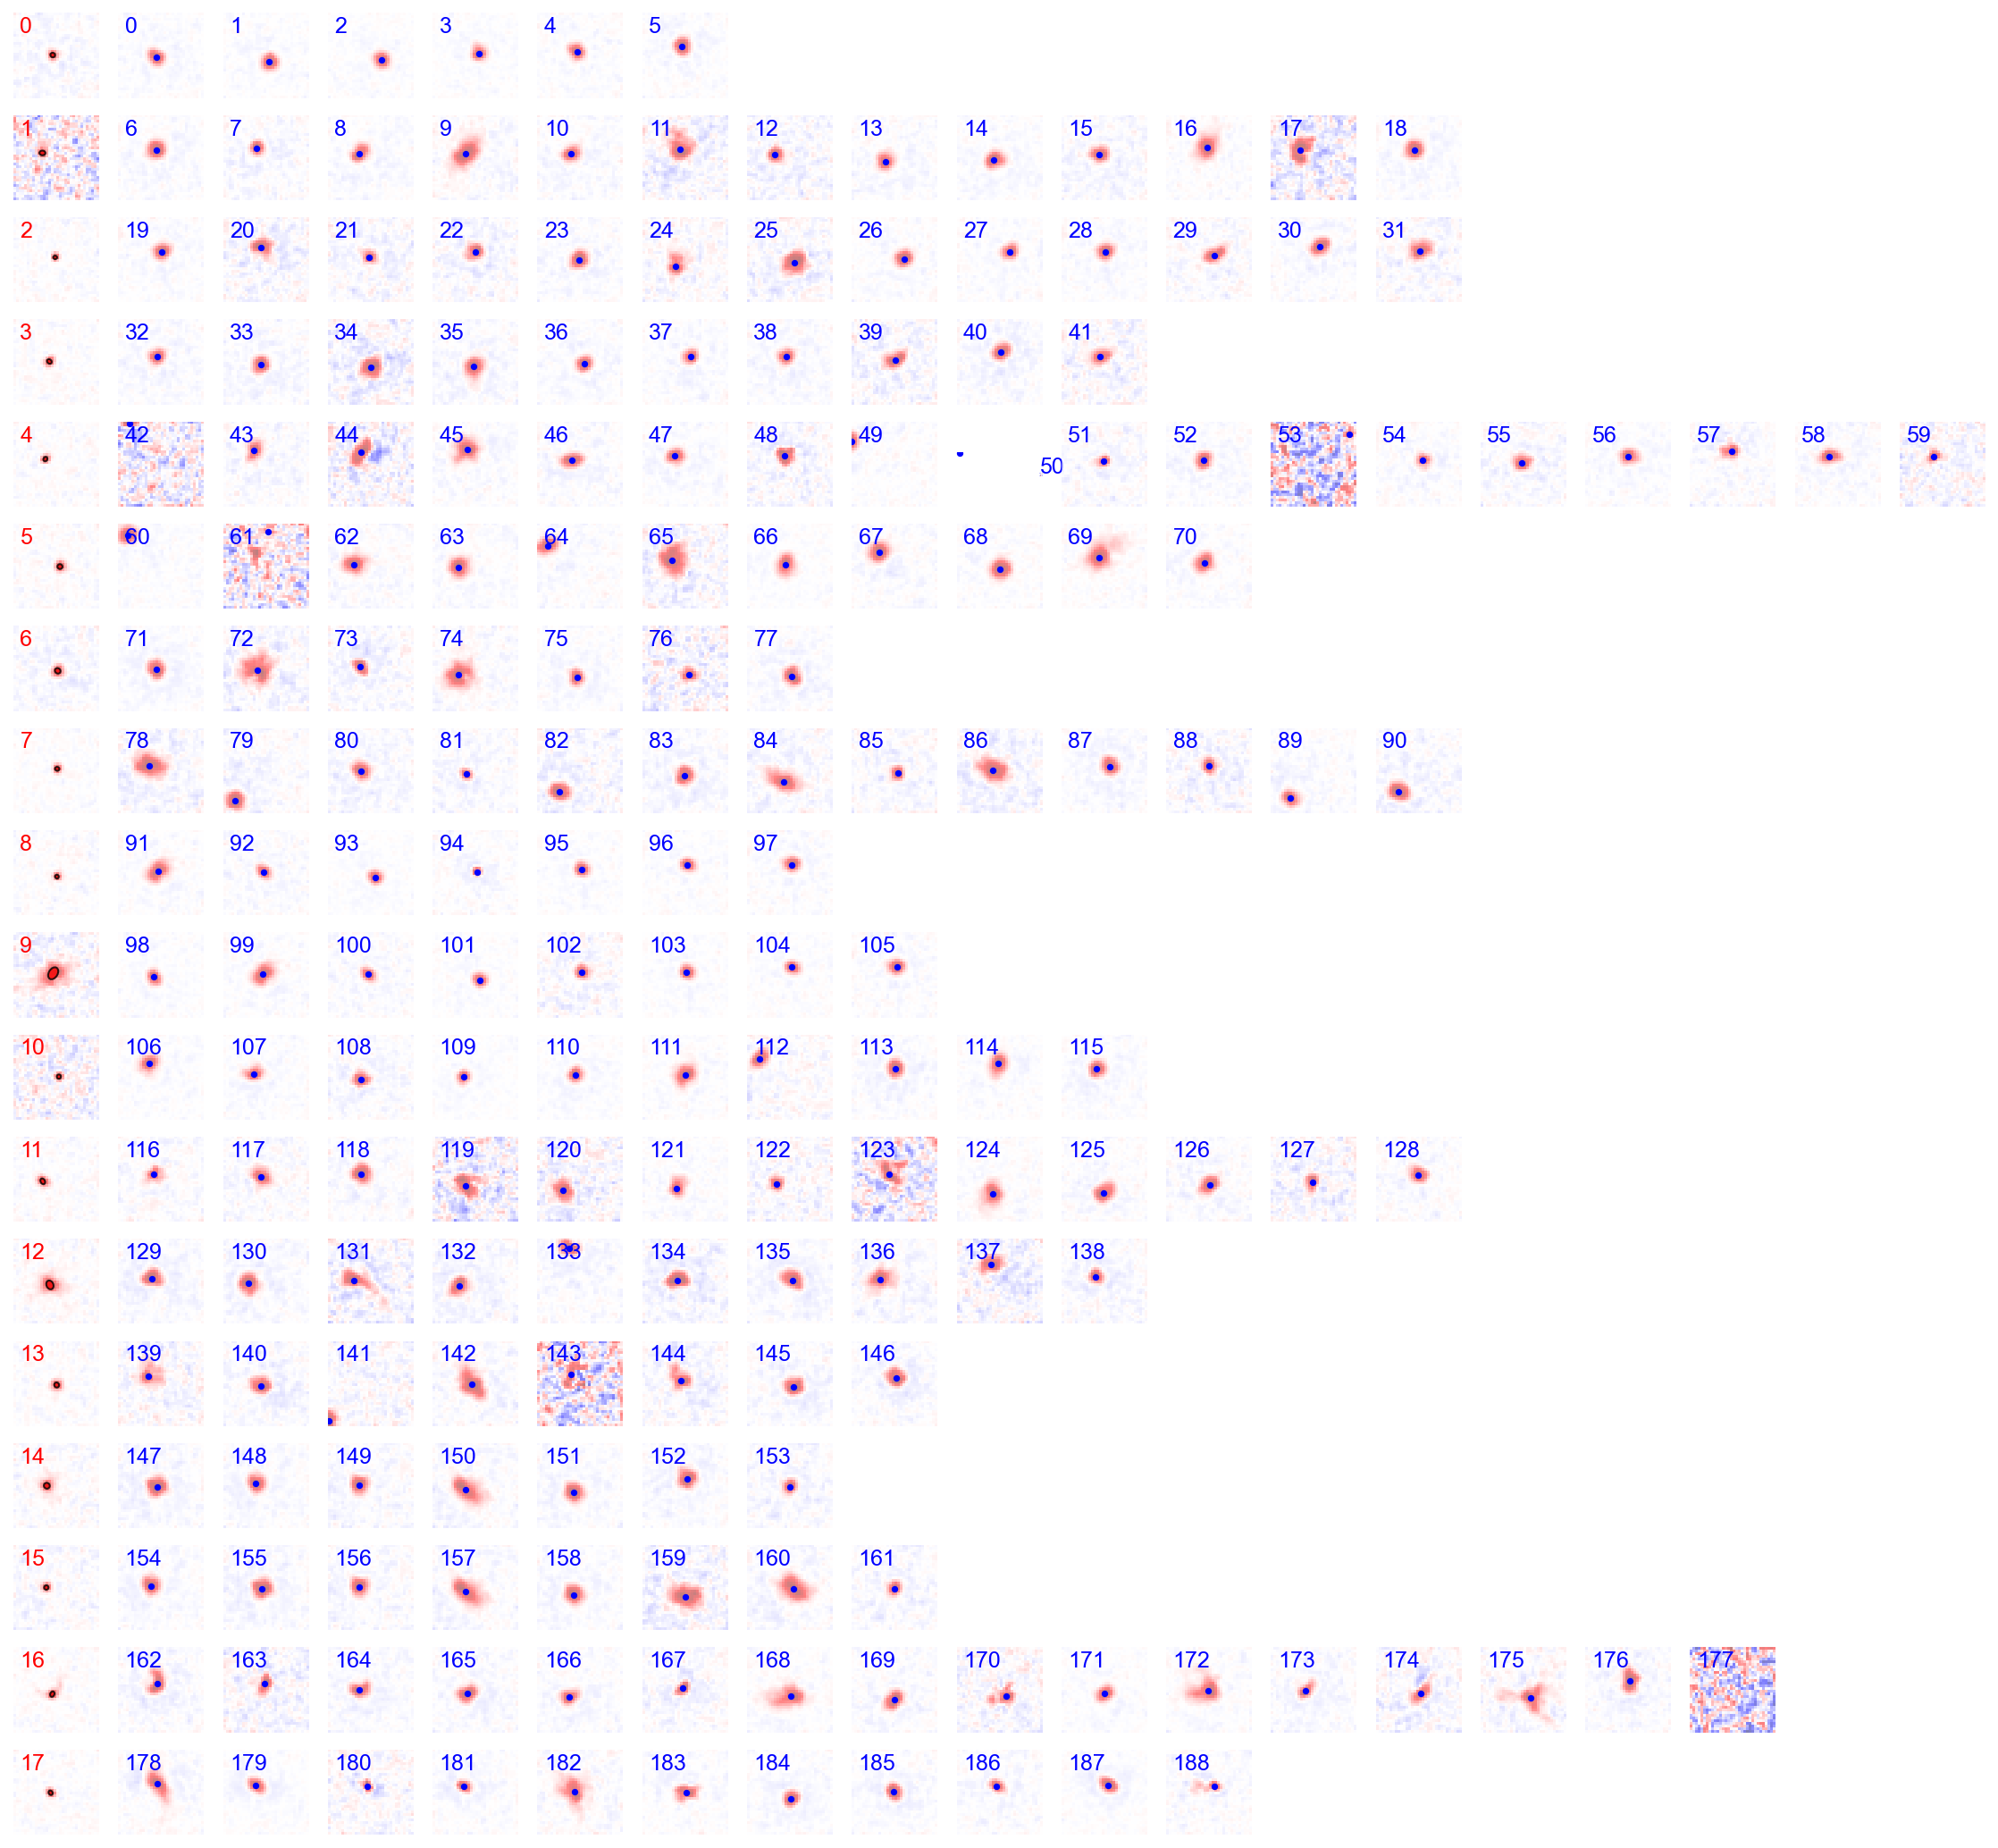

In [19]:
W = df['g_cell_num'].max() + 1
H = df['exp_id'].max() + 1
fig = plt.figure(figsize=(1 * W, 1 * H))
g_idx = 0
for i in range(H):
    # intracell
    ax = plt.subplot(H, W, i * W + 1)
    img = ex.rf['i']['space'][i]
    im = ax.imshow(img.T, extent=[-0.5, 31.5, 31.5, -0.5],
                   cmap='seismic', vmin=-np.max(abs(img)), vmax=np.max(abs(img)), interpolation='nearest', alpha=0.5)
    ax.text(2, 7, i, color='r')
    ell = matplotlib.patches.Ellipse(xy=(ex.rf['i']['ellipse'][i][0], ex.rf['i']['ellipse'][i][1]), 
                                         width=ex.rf['i']['ellipse'][i][2],
                                         height=ex.rf['i']['ellipse'][i][3],
                                         angle=ex.rf['i']['ellipse'][i][4],
                                         fc='red', ec='black', linewidth=1, alpha=0.8)
    ax.add_patch(ell)
    ax.axis('off')
    for g in range(df[df['exp_id'] == i]['g_cell_num'].iloc[0]):
        # ganglion
        ax = plt.subplot(H, W, ((i * W + g) + 1) + 1)
        img = ex.rf['g']['space'][g_idx]
        im = ax.imshow(img.T, extent=[-0.5, 31.5, 31.5, -0.5],
                       cmap='seismic', vmin=-np.max(abs(img)), vmax=np.max(abs(img)), interpolation='nearest', alpha=0.5)
        ax.text(2, 7, g_idx, color='b')
        ell = matplotlib.patches.Ellipse(xy=(ex.rf['g']['ellipse'][g_idx][0], ex.rf['g']['ellipse'][g_idx][1]), 
                                         width=ex.rf['g']['ellipse'][g_idx][2],
                                         height=ex.rf['g']['ellipse'][g_idx][3],
                                         angle=ex.rf['g']['ellipse'][g_idx][4],
                                         fc='blue', ec='black', linewidth=1, alpha=0.8)
        # To confirm discrepancy between axes of plt.imshow and plt.plot 
        #ax.plot([20], [30], 'r.', markersize=3)
        ax.plot([ex.rf['g']['ellipse'][g_idx][0]], [ex.rf['g']['ellipse'][g_idx][1]], 'b.', markersize=5)

        #ax.add_patch(ell)
        ax.axis('off')
        g_idx += 1
print("Caution!!!!!!!!!!!!!!! These images were rotated to match with ellipse, so be careful!")

In [20]:
print('NOTE: Again, these receptive fields are rotated !')

NOTE: Again, these receptive fields are rotated !


### 2-02. Saves filtering indexes, rf diameter size, and centoring indexes & add them to pandas.DataFrame

In [21]:
# add a 'filtering' index to use cells showing calculated location is at the center of receptive field
f_rf = np.ones(N_g)
f_rf[[42, 50, 53, 61, 177]] = 0
f_rf.shape
df = df.assign(f_rf=f_rf)

In [22]:
# add diameter of ganglion cell decomposed spatial receptive field (fit with gaussian sigma=1)
g_rf_size = list((8 * (ex.rf['g']['ellipse'][g][2] + 
                       ex.rf['g']['ellipse'][g][3]) * (100/17)) for g in range(N_g))    # [um]
i_rf_size = list((8 * (ex.rf['i']['ellipse'][i][2] + 
                       ex.rf['i']['ellipse'][i][3]) * (100/17)) for i in range(N_i))    # [um]
g_rf_size_arr = np.array(g_rf_size)
i_rf_size_arr = np.hstack([np.repeat(i_rf_size[i], df[df['exp_id'] == i]['g_cell_num'].iloc[0]) for i in range(N_i)])
df = df.assign(g_rf_size=g_rf_size_arr)
df = df.assign(i_rf_size=i_rf_size_arr)

#### **Caution:  ex.rf['g' or 'i']['ellipse'][idx][1] is the index / (15.5, 15.5) is the center

In [23]:
'''
8 * (15.5 - ex.rf['g']['ellipse'][g_idx][1])        # to align ganglion cells to center [pixel]
                                                    # & intracell to relative position where ganglion cells at center
8 * (15.5 - ex.rf['i']['ellipse'][i_idx][1])        # to align intracell to center [pixel]
                                                    # & ganglion cells to relative position where intracell at center
8 * (ex.rf['i']['ellipse'][i_idx][1] - ex.rf['g']['ellipse'][g_idx][1])   # to measure relative distance between pairs
8 * (ex.rf['i']['ellipse'][i_idx][0] - ex.rf['g']['ellipse'][g_idx][0])   # unit: [pixel]
'''

"\n8 * (15.5 - ex.rf['g']['ellipse'][g_idx][1])        # to align ganglion cells to center [pixel]\n                                                    # & intracell to relative position where ganglion cells at center\n8 * (15.5 - ex.rf['i']['ellipse'][i_idx][1])        # to align intracell to center [pixel]\n                                                    # & ganglion cells to relative position where intracell at center\n8 * (ex.rf['i']['ellipse'][i_idx][1] - ex.rf['g']['ellipse'][g_idx][1])   # to measure relative distance between pairs\n8 * (ex.rf['i']['ellipse'][i_idx][0] - ex.rf['g']['ellipse'][g_idx][0])   # unit: [pixel]\n"

In [24]:
cen_g_idx1 = np.stack([8 * (15.5 - ex.rf['g']['ellipse'][g][0]) for g in range(N_g)])
cen_g_idx2 = np.stack([8 * (15.5 - ex.rf['g']['ellipse'][g][1]) for g in range(N_g)])   # moving bar direction
cen_g_idx1[177] = 0                                                                     # to deal with NaN value
cen_g_idx2[177] = 0
cen_i_idx1 = np.hstack([np.repeat(8 * (15.5 - ex.rf['i']['ellipse'][i][0]), 
                                  df[df['exp_id'] == i]['g_cell_num'].iloc[0]) 
                        for i in range(N_i)])
cen_i_idx2 = np.hstack([np.repeat(8 * (15.5 - ex.rf['i']['ellipse'][i][1]), 
                                  df[df['exp_id'] == i]['g_cell_num'].iloc[0]) 
                        for i in range(N_i)])                                           # moving bar direction
i_g_idx1 = cen_g_idx1 - cen_i_idx1
i_g_idx2 = cen_g_idx2 - cen_i_idx2                                                      # moving bar direction
df = df.assign(cen_g_idx1=cen_g_idx1)                                 # [pixel]
df = df.assign(cen_g_idx2=cen_g_idx2)
df = df.assign(cen_i_idx1=cen_i_idx1)
df = df.assign(cen_i_idx2=cen_i_idx2)
df = df.assign(i_g_idx1=i_g_idx1)
df = df.assign(i_g_idx2=i_g_idx2)
df = df.assign(i_g_dist=((i_g_idx2**2 + i_g_idx1**2)**0.5)*(100/17))  # [micrometer]

(array([ 8., 22., 38., 30., 31., 24., 14.,  2.,  3.,  2.,  1.,  0.,  0.,
         2.,  0.,  1.,  4.,  0.,  2.,  1.,  0.,  1.,  0.,  1.,  1.]),
 array([   0.,   40.,   80.,  120.,  160.,  200.,  240.,  280.,  320.,
         360.,  400.,  440.,  480.,  520.,  560.,  600.,  640.,  680.,
         720.,  760.,  800.,  840.,  880.,  920.,  960., 1000.]),
 <BarContainer object of 25 artists>)

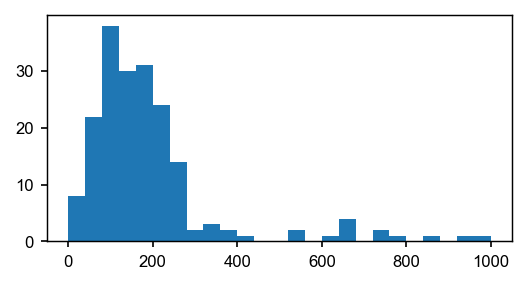

In [25]:
plt.hist(df['i_g_dist'], 25, (0, 1000))

### 2-03. Classify functional types

In [26]:
pca_g = sklearn.decomposition.PCA(n_components=2) # <= N_g
X_g = np.stack([ex.rf['g']['time'][g][:] for g in range(N_g)])
#X_g = np.hstack([np.stack([ex.rf['g']['time'][g][:] for g in range(N_g)]),
#                 np.stack([ft.decompose(ft.cutout(ft.smooth(np.pad(ex.rf['g']['st'][g], 
#                                                                   ((0, 0), (10, 10), (10, 10)), mode='constant'), 
#                                                            0.5), width=10))[0][10, :] for g in range(N_g)]),
#                 np.stack([np.nanmean(ex.g['flash_1'][g], axis=0) for g in range(N_g)])])
X_g_tr = pca_g.fit_transform(X_g)

pca_i = sklearn.decomposition.PCA(n_components=2) # <= N_i
X_i = np.stack([ex.rf['i']['time'][i][:] for i in range(N_i)])
#X_i = np.hstack([np.stack([ex.rf['i']['time'][i][:] for i in range(N_i)]), 
#                 np.stack([np.roll(scipy.signal.resample(np.nanmean(ex.i['mb_ad_ao'][i][0, 1, :, :], axis=0), 129), 
#                                   int(np.round(df[(df['exp_id'] == i)]['cen_i_idx2'].unique()/2))) for i in range(N_i)])])
X_i_tr = pca_i.fit_transform(X_i)
X_g_tr.shape, X_i_tr.shape

((189, 2), (18, 2))

In [27]:
N_g_cluster = 5
N_i_cluster = 2
kmeans_g = sklearn.cluster.KMeans(n_clusters=N_g_cluster, init='k-means++', random_state=0).fit(X_g_tr)
kmeans_i = sklearn.cluster.KMeans(n_clusters=N_i_cluster, init='k-means++', random_state=0).fit(X_i_tr)

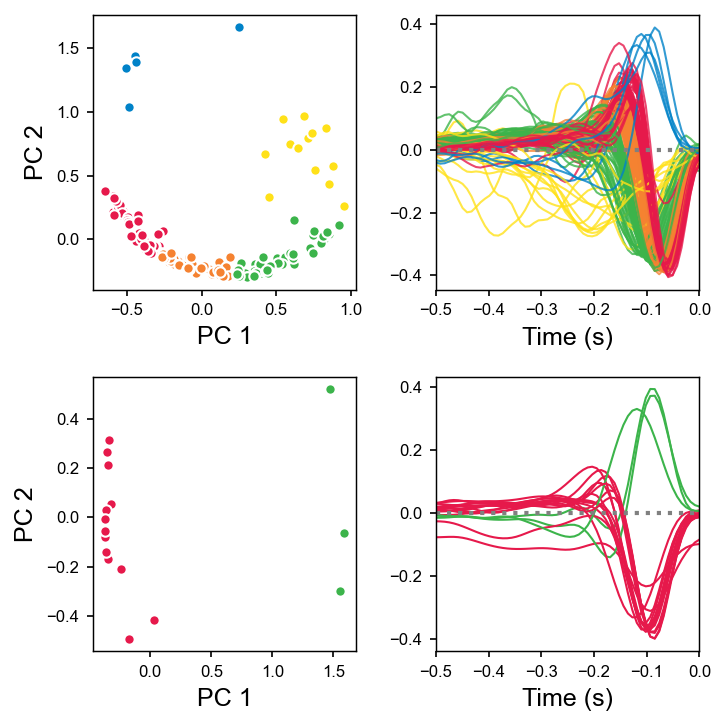

In [45]:
fig = plt.figure(figsize=(5, 5))
ax = plt.subplot(2, 2, 1)
for g in range(N_g):
    ax.plot(X_g_tr[g, 0], X_g_tr[g, 1], color=c_idx[kmeans_g.labels_[g]], marker='.', 
            markersize=10, markeredgecolor='white')
    #ax.text(X_g_tr[g, 0]+0.02*np.random.rand(1), X_g_tr[g, 1]+0.02*np.random.rand(1), kmeans_g.labels_[g], size=7)
ax.set_xlabel('PC 1')  
ax.set_ylabel('PC 2')    
ax = plt.subplot(2, 2, 2)    
for g in range(N_g):
    ax.plot(np.linspace(-0.5, 0, 60), ex.rf['g']['time'][g], color=c_idx[kmeans_g.labels_[g]], alpha=0.8)
ax.axhline(0, color='gray', linestyle=':', linewidth=2)
ax.set_xlabel('Time (s)')  
ax.set_xlim(-0.5, 0)
ax = plt.subplot(2, 2, 3)
for i in range(N_i):
    ax.plot(X_i_tr[i, 0], X_i_tr[i, 1], color=c_idx[kmeans_i.labels_[i]], marker='.', 
            markersize=10, markeredgecolor='white')
    #ax.text(X_i_tr[i, 0]+0.02*np.random.rand(1), X_i_tr[i, 1]+0.02*np.random.rand(1), kmeans_i.labels_[i], size=7)
ax.set_xlabel('PC 1')  
ax.set_ylabel('PC 2')
ax = plt.subplot(2, 2, 4)    
for i in range(N_i):
    ax.plot(np.linspace(-0.5, 0, 60), ex.rf['i']['time'][i], color=c_idx[kmeans_i.labels_[i]])
ax.axhline(0, color='gray', linestyle=':', linewidth=2)
ax.set_xlim(-0.5, 0)
ax.set_xlabel('Time (s)')  
plt.tight_layout()
#plt.savefig('fig_rf+cluster.png', dpi=300)

### 2-04. Save classification indexes add to pandas.DataFrame

In [29]:
g_classify_idx = kmeans_g.labels_
i_classify_idx = np.hstack([np.repeat(kmeans_i.labels_[i], df[df['exp_id'] == i]['g_cell_num'].iloc[0]) for i in range(N_i)])
df = df.assign(g_classify_idx=g_classify_idx)
df = df.assign(i_classify_idx=i_classify_idx)

### 2-05. Save other indexes, calculated parameters, statistics to pandas.DataFrame

In [30]:
# ganglion firing rate of ['rf_30m'] 
g_fr_rf_30m = np.array(list(np.sum(ex.g['rf_30m'][g]) for g in range(N_g))) / (ex.tbins['rf_30m'][0][-1] + ex.tbins['rf_30m'][0][1])
df = df.assign(g_fr_rf_30m=g_fr_rf_30m)

In [31]:
# for the first experiment version, use first half trial of the 'control' case
use_half_con_trial = 1 - (np.array(df['exp_version']) - 1)    # 'exp_version' == 1 recorded first half for control trial ('exp_version' == 2 recorded full)
df = df.assign(use_half_con_trial=use_half_con_trial)

# ganglion pairwise correlation across trials during moving bar experiment (control, average between (n)ad & (n)da)
mb_ad_con_cc = np.zeros((N_g,))
mb_da_con_cc = np.zeros((N_g,))
mb_2ad_con_cc = np.zeros((N_g,))
mb_2da_con_cc = np.zeros((N_g,))
mb_4ad_con_cc = np.zeros((N_g,))
mb_4da_con_cc = np.zeros((N_g,))
mb_ad_con_cc[:] = np.nan 
mb_da_con_cc[:] = np.nan 
mb_2ad_con_cc[:] = np.nan 
mb_2da_con_cc[:] = np.nan 
mb_4ad_con_cc[:] = np.nan 
mb_4da_con_cc[:] = np.nan 
for g in df[df['mb_ad']==1]['g_cell_id'].iloc():
    mb_ad_con_cc[g] = np.nanmean(np.nanmean(stats.corr(ex.g['mb_ad'][g], mode='pair', 
                                                       use_half_trial=df['use_half_con_trial'][g]), axis=2), axis=0)[0, 0]
    mb_da_con_cc[g] = np.nanmean(np.nanmean(stats.corr(ex.g['mb_da'][g], mode='pair', 
                                                       use_half_trial=df['use_half_con_trial'][g]), axis=2), axis=0)[0, 0]
for g in df[df['mb_2ad']==1]['g_cell_id'].iloc():
    mb_2ad_con_cc[g] = np.nanmean(np.nanmean(stats.corr(ex.g['mb_2ad'][g], mode='pair', 
                                                        use_half_trial=df['use_half_con_trial'][g]), axis=2), axis=0)[0, 0]
    mb_2da_con_cc[g] = np.nanmean(np.nanmean(stats.corr(ex.g['mb_2da'][g], mode='pair', 
                                                        use_half_trial=df['use_half_con_trial'][g]), axis=2), axis=0)[0, 0]
for g in df[df['mb_4ad']==1]['g_cell_id'].iloc():
    mb_4ad_con_cc[g] = np.nanmean(np.nanmean(stats.corr(ex.g['mb_4ad'][g], mode='pair', 
                                                        use_half_trial=df['use_half_con_trial'][g]), axis=2), axis=0)[0, 0]
    mb_4da_con_cc[g] = np.nanmean(np.nanmean(stats.corr(ex.g['mb_4da'][g], mode='pair', 
                                                        use_half_trial=df['use_half_con_trial'][g]), axis=2), axis=0)[0, 0]
    
mb_1_con_cc_pair = np.nanmean(np.stack([mb_ad_con_cc, mb_da_con_cc]), axis=0)
mb_2_con_cc_pair = np.nanmean(np.stack([mb_2ad_con_cc, mb_2da_con_cc]), axis=0)
mb_4_con_cc_pair = np.nanmean(np.stack([mb_4ad_con_cc, mb_4da_con_cc]), axis=0)
g_mb_con_cc_pair = np.nanmean(np.stack([mb_1_con_cc_pair, mb_2_con_cc_pair, mb_4_con_cc_pair]), axis=0)
df = df.assign(mb_1_con_cc_pair=mb_1_con_cc_pair)
df = df.assign(mb_2_con_cc_pair=mb_2_con_cc_pair)
df = df.assign(mb_4_con_cc_pair=mb_4_con_cc_pair)
df = df.assign(g_mb_con_cc_pair=g_mb_con_cc_pair)

/home/dlee/moving-bar/venv/lib/python3.8/site-packages/scipy/stats/stats.py:3845: PearsonRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(PearsonRConstantInputWarning())
<ipython-input-31-676cb90e03a1>:19: RuntimeWarning: Mean of empty slice
  mb_ad_con_cc[g] = np.nanmean(np.nanmean(stats.corr(ex.g['mb_ad'][g], mode='pair',
<ipython-input-31-676cb90e03a1>:21: RuntimeWarning: Mean of empty slice
  mb_da_con_cc[g] = np.nanmean(np.nanmean(stats.corr(ex.g['mb_da'][g], mode='pair',
/home/dlee/moving-bar/venv/lib/python3.8/site-packages/scipy/stats/stats.py:3845: PearsonRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(PearsonRConstantInputWarning())
<ipython-input-31-676cb90e03a1>:24: RuntimeWarning: Mean of empty slice
  mb_2ad_con_cc[g] = np.nanmean(np.nanmean(stats.corr(ex.g['mb_2ad'][g], mode='pair',
<ipython-input-31-676cb90e03a1>:26: RuntimeWarning: Mean of empty sl

In [32]:
# ganglion firing rate of ['mb_(n)ad'] & ['mb_(n)da'], control cases
fr_mb_ad_con = np.zeros((N_g,))
fr_mb_da_con = np.zeros((N_g,))
fr_mb_2ad_con = np.zeros((N_g,))
fr_mb_2da_con = np.zeros((N_g,))
fr_mb_4ad_con = np.zeros((N_g,))
fr_mb_4da_con = np.zeros((N_g,))
fr_mb_ad_con[:] = np.nan 
fr_mb_da_con[:] = np.nan
fr_mb_2ad_con[:] = np.nan
fr_mb_2da_con[:] = np.nan
fr_mb_4ad_con[:] = np.nan
fr_mb_4da_con[:] = np.nan

for g in df[df['mb_ad']==1]['g_cell_id'].iloc():
    fr_mb_ad_con[g] = stats.mean(ex.g['mb_ad'][g], axis=(0, 2, 3), use_half_trial=df['use_half_con_trial'][g])[0] / ex.tbins['mb_ad'][0][1]
    fr_mb_da_con[g] = stats.mean(ex.g['mb_da'][g], axis=(0, 2, 3), use_half_trial=df['use_half_con_trial'][g])[0] / ex.tbins['mb_ad'][0][1]
for g in df[df['mb_2ad']==1]['g_cell_id'].iloc():
    fr_mb_2ad_con[g] = stats.mean(ex.g['mb_2ad'][g], axis=(0, 2, 3), use_half_trial=df['use_half_con_trial'][g])[0] / ex.tbins['mb_ad'][0][1]
    fr_mb_2da_con[g] = stats.mean(ex.g['mb_2da'][g], axis=(0, 2, 3), use_half_trial=df['use_half_con_trial'][g])[0] / ex.tbins['mb_ad'][0][1]
for g in df[df['mb_4ad']==1]['g_cell_id'].iloc():
    fr_mb_4ad_con[g] = stats.mean(ex.g['mb_4ad'][g], axis=(0, 2, 3), use_half_trial=df['use_half_con_trial'][g])[0] / ex.tbins['mb_ad'][0][1]
    fr_mb_4da_con[g] = stats.mean(ex.g['mb_4da'][g], axis=(0, 2, 3), use_half_trial=df['use_half_con_trial'][g])[0] / ex.tbins['mb_ad'][0][1]
    
fr_mb_1_con = np.nanmean(np.stack([fr_mb_ad_con, fr_mb_da_con]), axis=0)
fr_mb_2_con = np.nanmean(np.stack([fr_mb_2ad_con, fr_mb_2da_con]), axis=0)
fr_mb_4_con = np.nanmean(np.stack([fr_mb_4ad_con, fr_mb_4da_con]), axis=0)
g_fr_mb_con = np.nanmean(np.stack([fr_mb_1_con, fr_mb_2_con, fr_mb_4_con]), axis=0)
df = df.assign(fr_mb_1_con=fr_mb_1_con)
df = df.assign(fr_mb_2_con=fr_mb_2_con)
df = df.assign(fr_mb_4_con=fr_mb_4_con)
df = df.assign(g_fr_mb_con=g_fr_mb_con)

<ipython-input-32-89303bdfc155>:25: RuntimeWarning: Mean of empty slice
  fr_mb_1_con = np.nanmean(np.stack([fr_mb_ad_con, fr_mb_da_con]), axis=0)
<ipython-input-32-89303bdfc155>:26: RuntimeWarning: Mean of empty slice
  fr_mb_2_con = np.nanmean(np.stack([fr_mb_2ad_con, fr_mb_2da_con]), axis=0)
<ipython-input-32-89303bdfc155>:27: RuntimeWarning: Mean of empty slice
  fr_mb_4_con = np.nanmean(np.stack([fr_mb_4ad_con, fr_mb_4da_con]), axis=0)


In [33]:
# ganglion pairwise correlation across trials during 'flash_1' experiment 
g_flash_cc_pair = np.array(list(np.nanmean(stats.corr(ex.g['flash_1'][g]), axis=0)[0] for g in range(N_g)))
g_flash_cc_pair[np.isnan(g_flash_cc_pair)] = 0
df = df.assign(g_flash_cc_pair=g_flash_cc_pair)

/home/dlee/moving-bar/venv/lib/python3.8/site-packages/scipy/stats/stats.py:3845: PearsonRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(PearsonRConstantInputWarning())
<ipython-input-33-6fbe8ccfa0ae>:2: RuntimeWarning: Mean of empty slice
  g_flash_cc_pair = np.array(list(np.nanmean(stats.corr(ex.g['flash_1'][g]), axis=0)[0] for g in range(N_g)))


In [34]:
# ganglion firing rate of ['flash_1'], on (%) & off (%) & average firing rage (Hz)
g_fr_flash_on = np.array(list((np.sum(ex.g['flash_1'][g][:, :61]) / np.sum(ex.g['flash_1'][g])) for g in range(N_g)))   # on for 1 s
g_fr_flash_off = np.array(list((np.sum(ex.g['flash_1'][g][:, 61:]) / np.sum(ex.g['flash_1'][g])) for g in range(N_g)))  # off for 1 s
g_fr_flash = np.array(list((np.nanmean(ex.g['flash_1'][g]) / ex.tbins['flash_1'][0][1]) for g in range(N_g)))
g_fr_flash_on[np.isnan(g_fr_flash_on)] = 0
g_fr_flash_off[np.isnan(g_fr_flash_off)] = 0
g_fr_flash[np.isnan(g_fr_flash)] = 0
df = df.assign(g_fr_flash_on=g_fr_flash_on)
df = df.assign(g_fr_flash_off=g_fr_flash_off)
df = df.assign(g_fr_flash=g_fr_flash)

<ipython-input-34-fb748229d607>:2: RuntimeWarning: invalid value encountered in double_scalars
  g_fr_flash_on = np.array(list((np.sum(ex.g['flash_1'][g][:, :61]) / np.sum(ex.g['flash_1'][g])) for g in range(N_g)))   # on for 1 s
<ipython-input-34-fb748229d607>:3: RuntimeWarning: invalid value encountered in double_scalars
  g_fr_flash_off = np.array(list((np.sum(ex.g['flash_1'][g][:, 61:]) / np.sum(ex.g['flash_1'][g])) for g in range(N_g)))  # off for 1 s


In [35]:
# intracell pairwise correlation across trials during moving bar experiment (before playback experiment)
i_mb_cc_pair_list = np.array(list(np.nanmean(stats.corr(ex.i['mb'][i]), axis=(0, 1))[0] for i in range(N_i)))
i_mb_cc_pair = np.hstack([np.repeat(i_mb_cc_pair_list[i], df[df['exp_id'] == i]['g_cell_num'].iloc[0]) for i in range(N_i)])
df = df.assign(i_mb_cc_pair=i_mb_cc_pair)

# intracell pairwise correlation across trials during 'flash_1' experiment
i_flash_cc_pair_list = np.array(list(np.nanmean(stats.corr(ex.i['flash_1'][i]), axis=0)[0] for i in range(N_i)))
i_flash_cc_pair = np.hstack([np.repeat(i_flash_cc_pair_list[i], df[df['exp_id'] == i]['g_cell_num'].iloc[0]) for i in range(N_i)])
df = df.assign(i_flash_cc_pair=i_flash_cc_pair)

In [36]:
# ganglion firing rate (added number of spikes) of ['mb_ns'], trial average
g_spk_mb_ns = np.zeros((N_g,))
g_spk_mb_ns[:] = np.nan
for g in df[df['mb_ns']==1]['g_cell_id'].iloc():
    g_spk_mb_ns[g] = np.nanmean(np.sum(ex.g['mb_ns'][g], axis=3))
df = df.assign(g_spk_mb_ns=g_spk_mb_ns)

In [37]:
# ganglion firing rate (added number of spikes) of ['rf_wn']
g_spk_rf_wn = np.zeros((N_g,))
g_delta_fr_rf_wn = np.zeros((N_g,))
g_spk_rf_wn[:] = np.nan
g_delta_fr_rf_wn[:] = np.nan
for g in df[df['rf_wn']==1]['g_cell_id'].iloc():
    g_spk_rf_wn[g] = np.sum(ex.g['rf_wn'][g])
    g_delta_fr_rf_wn[g] = np.sum(ex.g['rf_wn'][g]) / np.sum(ex.g['rf_30m'][g][:72000])
df = df.assign(g_spk_rf_wn=g_spk_rf_wn)
df = df.assign(g_delt_fr_rf_wn=g_delta_fr_rf_wn)

In [38]:
# saves ganglion- & intracell-centored moving bar results in ex.g_a (ex.g_analysis)
ex.g_a = {}
ex.i_a = {}
# ------------

# 'G'-center

# this means ganglion cells at the center (intracell effects location will be different spatially)  'G'-center
cen_g_idx2_mb_l = np.round(df['cen_g_idx2'].to_numpy()/2).astype(int)
cen_g_idx2_mb_r = np.round(-df['cen_g_idx2'].to_numpy()/2).astype(int)
ex.g_a['mb_ad_cen_g'] = list(analysis.mb_roll(ex.g['mb_ad'][g], (cen_g_idx2_mb_l[g], cen_g_idx2_mb_r[g])) for g in range(N_g))
ex.g_a['mb_da_cen_g'] = list(analysis.mb_roll(ex.g['mb_da'][g], (cen_g_idx2_mb_l[g], cen_g_idx2_mb_r[g])) for g in range(N_g))
ex.g_a['mb_2ad_cen_g'] = list(analysis.mb_roll(ex.g['mb_2ad'][g], (cen_g_idx2_mb_l[g], cen_g_idx2_mb_r[g])) for g in range(N_g))
ex.g_a['mb_2da_cen_g'] = list(analysis.mb_roll(ex.g['mb_2da'][g], (cen_g_idx2_mb_l[g], cen_g_idx2_mb_r[g])) for g in range(N_g))
ex.g_a['mb_4ad_cen_g'] = list(analysis.mb_roll(ex.g['mb_4ad'][g], (cen_g_idx2_mb_l[g], cen_g_idx2_mb_r[g])) for g in range(N_g))
ex.g_a['mb_4da_cen_g'] = list(analysis.mb_roll(ex.g['mb_4da'][g], (cen_g_idx2_mb_l[g], cen_g_idx2_mb_r[g])) for g in range(N_g))
ex.g_a['mb_ns_cen_g'] = list(analysis.mb_roll(ex.g['mb_ns'][g], (cen_g_idx2_mb_l[g], cen_g_idx2_mb_r[g])) for g in range(N_g))

# space index for intracell & changed firing rate of ganglion cells
i_2px_binspace_idx_cen_g = np.array(list(np.round(63.5 + df['i_g_idx2'][g]/2) for g in range(N_g))).astype(int)  # G'-center
df = df.assign(i_2px_binspace_idx_cen_g=i_2px_binspace_idx_cen_g)

# intracell
ex.i_a['mb_cen_g'] = np.stack([analysis.mb_roll(analysis.i_downsample(ex.i['mb'][df['exp_id'][g]][:, None, :, :], 129), 
                                                (cen_g_idx2_mb_l[g], cen_g_idx2_mb_r[g]), pad_mode='edge') for g in range(N_g)])
ex.i_a['mb_mean_cen_g'] = np.nanmean(ex.i_a['mb_cen_g'], 3, keepdims=True)
ex.i_a['mb_baseline_cen_g'] = np.nanmean(np.concatenate([ex.i_a['mb_mean_cen_g'][:, :, 0, 0, :10], 
                                                         ex.i_a['mb_mean_cen_g'][:, :, 0, 0, -10:]], axis=-1), axis=2)
ex.i_a['mb_baseline0_cen_g'] = ex.i_a['mb_cen_g'] - ex.i_a['mb_baseline_cen_g'][:, :, None, None, None]
ex.i_a['mb_ao_cen_g'] = np.stack([analysis.mb_roll(analysis.i_downsample(ex.i['mb_ad_ao'][df['exp_id'][g]], 129), 
                                                   (cen_g_idx2_mb_l[g], cen_g_idx2_mb_r[g]), pad_mode='edge') for g in range(N_g)])

# ------------

# 'I'-center

# this means intracells at the center (intracell effects are at the center) 'I'-center
cen_i_idx2_mb_l = np.round(df['cen_i_idx2'].to_numpy()/2).astype(int)
cen_i_idx2_mb_r = np.round(-df['cen_i_idx2'].to_numpy()/2).astype(int)
ex.g_a['mb_ad_cen_i'] = list(analysis.mb_roll(ex.g['mb_ad'][g], (cen_i_idx2_mb_l[g], cen_i_idx2_mb_r[g])) for g in range(N_g))
ex.g_a['mb_da_cen_i'] = list(analysis.mb_roll(ex.g['mb_da'][g], (cen_i_idx2_mb_l[g], cen_i_idx2_mb_r[g])) for g in range(N_g))
ex.g_a['mb_2ad_cen_i'] = list(analysis.mb_roll(ex.g['mb_2ad'][g], (cen_i_idx2_mb_l[g], cen_i_idx2_mb_r[g])) for g in range(N_g))
ex.g_a['mb_2da_cen_i'] = list(analysis.mb_roll(ex.g['mb_2da'][g], (cen_i_idx2_mb_l[g], cen_i_idx2_mb_r[g])) for g in range(N_g))
ex.g_a['mb_4ad_cen_i'] = list(analysis.mb_roll(ex.g['mb_4ad'][g], (cen_i_idx2_mb_l[g], cen_i_idx2_mb_r[g])) for g in range(N_g))
ex.g_a['mb_4da_cen_i'] = list(analysis.mb_roll(ex.g['mb_4da'][g], (cen_i_idx2_mb_l[g], cen_i_idx2_mb_r[g])) for g in range(N_g))
ex.g_a['mb_ns_cen_i'] = list(analysis.mb_roll(ex.g['mb_ns'][g], (cen_i_idx2_mb_l[g], cen_i_idx2_mb_r[g])) for g in range(N_g))

# space index for ganglion cells & changed firing rate of ganglion cells
g_2px_binspace_idx_cen_i = np.array(list(np.round(63.5 - df['i_g_idx2'][g]/2) for g in range(N_g))).astype(int)  # for 128 (2 px bin) space, 'I'-center
df = df.assign(g_2px_binspace_idx_cen_i=g_2px_binspace_idx_cen_i)

# intracell
cen_i_idx2_mb_l_for_i = np.round(df['cen_i_idx2'].unique()/2).astype(int)
cen_i_idx2_mb_r_for_i = np.round(-df['cen_i_idx2'].unique()/2).astype(int)
ex.i_a['mb_cen_i'] = np.stack([analysis.mb_roll(analysis.i_downsample(ex.i['mb'][i][:, None, :, :], 129), 
                                                (cen_i_idx2_mb_l_for_i[i], cen_i_idx2_mb_r_for_i[i]), pad_mode='edge') for i in range(N_i)])
ex.i_a['mb_mean_cen_i'] = np.nanmean(ex.i_a['mb_cen_i'], 3, keepdims=True)
ex.i_a['mb_baseline_cen_i'] = np.nanmean(np.concatenate([ex.i_a['mb_mean_cen_i'][:, :, 0, 0, :10], 
                                                         ex.i_a['mb_mean_cen_i'][:, :, 0, 0, -10:]], axis=-1), axis=2)
ex.i_a['mb_baseline0_cen_i'] = ex.i_a['mb_cen_i'] - ex.i_a['mb_baseline_cen_i'][:, :, None, None, None]
ex.i_a['mb_ao_cen_i'] = np.stack([analysis.mb_roll(analysis.i_downsample(ex.i['mb_ad_ao'][i], 129), 
                                                   (cen_i_idx2_mb_l_for_i[i], cen_i_idx2_mb_r_for_i[i]), pad_mode='edge') for i in range(N_i)])

In [39]:
# Compute linear / linear-nonlinear(LN) model for ganglion cells and intracells
# load moving bar stimulus
bar_st = st.downsample(ex.stim['mb'][0].astype('double').T, 2)[0].T
bar_st[bar_st == 63] = -0.5
bar_st[bar_st == 127] = 0

# 'I' -center

# linear model (lin) and LN model (ReLU) for ganglion cells
ex.g_a['mb_lin_cen_i'] = list(analysis.mb_roll(np.stack([st.downsample(ft.linear_response(st.upsample(np.nanmean(ex.rf['g']['st'][g], axis=1).T, 4)[0].T[::-1],
                                                                                          st.upsample(bar_st, 2)[0]), 2)[0],
                                                         st.downsample(ft.linear_response(st.upsample(np.nanmean(ex.rf['g']['st'][g], axis=1).T, 4)[0].T[::-1],
                                                                                          st.upsample(bar_st[:, ::-1], 2)[0]), 2)[0]]).reshape(2, 1, 1, -1), 
                                               (cen_i_idx2_mb_l[g], cen_i_idx2_mb_r[g])) for g in range(N_g))
ex.g_a['mb_ln_cen_i'] = list(np.clip(analysis.mb_roll(np.stack([st.downsample(ft.linear_response(st.upsample(np.nanmean(ex.rf['g']['st'][g], axis=1).T, 4)[0].T[::-1],
                                                                                                 st.upsample(bar_st, 2)[0]), 2)[0],
                                                                st.downsample(ft.linear_response(st.upsample(np.nanmean(ex.rf['g']['st'][g], axis=1).T, 4)[0].T[::-1],
                                                                                                 st.upsample(bar_st[:, ::-1], 2)[0]), 2)[0]]).reshape(2, 1, 1, -1), 
                                                      (cen_i_idx2_mb_l[g], cen_i_idx2_mb_r[g])), 0, 100) for g in range(N_g))

# linear model for intracells (with checkerboard receptive field-st, line receptive field-line)
ex.i_a['mb_lin_st_cen_i'] = np.stack([analysis.mb_roll(np.stack([st.downsample(ft.linear_response(st.upsample(np.nanmean(ex.rf['i']['st'][i], axis=1).T, 4)[0].T[::-1], 
                                                                                                  st.upsample(bar_st, 2)[0]), 2)[0],
                                                                 st.downsample(ft.linear_response(st.upsample(np.nanmean(ex.rf['i']['st'][i], axis=1).T, 4)[0].T[::-1], 
                                                                                                  st.upsample(bar_st[:, ::-1], 2)[0]), 2)[0]]).reshape(2, 1, 1, -1), 
                                                       (cen_i_idx2_mb_l_for_i[i], cen_i_idx2_mb_r_for_i[i]), pad_mode='edge') for i in range(N_i)])
ex.i_a['mb_lin_line_cen_i'] = np.stack([analysis.mb_roll(np.stack([st.downsample(ft.linear_response(st.upsample(ex.rf['i']['line'][i].T, 2)[0].T[::-1], 
                                                                                                    st.upsample(bar_st, 2)[0]), 2)[0],
                                                                   st.downsample(ft.linear_response(st.upsample(ex.rf['i']['line'][i].T, 2)[0].T[::-1], 
                                                                                                    st.upsample(bar_st[:, ::-1], 2)[0]), 2)[0]]).reshape(2, 1, 1, -1),
                                                         (cen_i_idx2_mb_l_for_i[i], cen_i_idx2_mb_r_for_i[i]), pad_mode='edge') for i in range(N_i)])

In [40]:
# additional linear model for intracells with baseline zero-ed and amplitude matched [mV]
ex.i_a['mb_lin_st_baseline0_cen_i'] = np.zeros(ex.i_a['mb_lin_st_cen_i'].shape)
for i in range(N_i):
    for lr in range(2):
        tmp = ex.i_a['mb_lin_st_cen_i'][i, lr, 0, 0, :]
        tmp_baseline0 = tmp - np.nanmean(np.concatenate((tmp[:10], tmp[-10:])))
        if np.max(tmp_baseline0) >= abs(np.min(tmp_baseline0)):
            tmp_max = np.max(tmp_baseline0)
            tmp_baseline0 = tmp_baseline0 / tmp_max
            tmp_baseline0 = tmp_baseline0 * np.max(np.nanmean(ex.i_a['mb_baseline0_cen_i'][i, lr, 0], 0))
        else:
            tmp_max = abs(np.min(tmp_baseline0))
            tmp_baseline0 = tmp_baseline0 / tmp_max
            tmp_baseline0 = tmp_baseline0 * abs(np.min(np.nanmean(ex.i_a['mb_baseline0_cen_i'][i, lr, 0], 0)))
        ex.i_a['mb_lin_st_baseline0_cen_i'][i, lr, 0, 0, :] = tmp_baseline0
        
ex.i_a['mb_lin_line_baseline0_cen_i'] = np.zeros(ex.i_a['mb_lin_line_cen_i'].shape)
for i in range(N_i):
    for lr in range(2):
        tmp = ex.i_a['mb_lin_line_cen_i'][i, lr, 0, 0, :]
        tmp_baseline0 = tmp - np.nanmean(np.concatenate((tmp[:10], tmp[-10:])))
        if np.max(tmp_baseline0) >= abs(np.min(tmp_baseline0)):
            tmp_max = np.max(tmp_baseline0)
            tmp_baseline0 = tmp_baseline0 / tmp_max
            tmp_baseline0 = tmp_baseline0 * np.max(np.nanmean(ex.i_a['mb_baseline0_cen_i'][i, lr, 0], 0))
        else:
            tmp_max = abs(np.min(tmp_baseline0))
            tmp_baseline0 = tmp_baseline0 / tmp_max
            tmp_baseline0 = tmp_baseline0 * abs(np.min(np.nanmean(ex.i_a['mb_baseline0_cen_i'][i, lr, 0], 0)))
        ex.i_a['mb_lin_line_baseline0_cen_i'][i, lr, 0, 0, :] = tmp_baseline0

In [41]:
# to deal with NaN values in control trials for some early experiment versions
for g in range(N_g):
    if not np.isnan(ex.g_a['mb_ad_cen_g'][g]).shape == ():
        ex.g_a['mb_ad_cen_g'][g][:, 0, :, :] = utils.split_half_nan(ex.g_a['mb_ad_cen_g'][g][:, 0, :, :], use_half_trial=df['use_half_con_trial'][g])
        ex.g_a['mb_da_cen_g'][g][:, 0, :, :] = utils.split_half_nan(ex.g_a['mb_da_cen_g'][g][:, 0, :, :], use_half_trial=df['use_half_con_trial'][g])
    if not np.isnan(ex.g_a['mb_2ad_cen_g'][g]).shape == ():
        ex.g_a['mb_2ad_cen_g'][g][:, 0, :, :] = utils.split_half_nan(ex.g_a['mb_2ad_cen_g'][g][:, 0, :, :], use_half_trial=df['use_half_con_trial'][g])
        ex.g_a['mb_2da_cen_g'][g][:, 0, :, :] = utils.split_half_nan(ex.g_a['mb_2da_cen_g'][g][:, 0, :, :], use_half_trial=df['use_half_con_trial'][g])
    if not np.isnan(ex.g_a['mb_4ad_cen_g'][g]).shape == ():
        ex.g_a['mb_4ad_cen_g'][g][:, 0, :, :] = utils.split_half_nan(ex.g_a['mb_4ad_cen_g'][g][:, 0, :, :], use_half_trial=df['use_half_con_trial'][g])
        ex.g_a['mb_4da_cen_g'][g][:, 0, :, :] = utils.split_half_nan(ex.g_a['mb_4da_cen_g'][g][:, 0, :, :], use_half_trial=df['use_half_con_trial'][g])
    if not np.isnan(ex.g_a['mb_ad_cen_i'][g]).shape == ():
        ex.g_a['mb_ad_cen_i'][g][:, 0, :, :] = utils.split_half_nan(ex.g_a['mb_ad_cen_i'][g][:, 0, :, :], use_half_trial=df['use_half_con_trial'][g])
        ex.g_a['mb_da_cen_i'][g][:, 0, :, :] = utils.split_half_nan(ex.g_a['mb_da_cen_i'][g][:, 0, :, :], use_half_trial=df['use_half_con_trial'][g])
    if not np.isnan(ex.g_a['mb_2ad_cen_i'][g]).shape == ():
        ex.g_a['mb_2ad_cen_i'][g][:, 0, :, :] = utils.split_half_nan(ex.g_a['mb_2ad_cen_i'][g][:, 0, :, :], use_half_trial=df['use_half_con_trial'][g])
        ex.g_a['mb_2da_cen_i'][g][:, 0, :, :] = utils.split_half_nan(ex.g_a['mb_2da_cen_i'][g][:, 0, :, :], use_half_trial=df['use_half_con_trial'][g])
    if not np.isnan(ex.g_a['mb_4ad_cen_i'][g]).shape == ():
        ex.g_a['mb_4ad_cen_i'][g][:, 0, :, :] = utils.split_half_nan(ex.g_a['mb_4ad_cen_i'][g][:, 0, :, :], use_half_trial=df['use_half_con_trial'][g])
        ex.g_a['mb_4da_cen_i'][g][:, 0, :, :] = utils.split_half_nan(ex.g_a['mb_4da_cen_i'][g][:, 0, :, :], use_half_trial=df['use_half_con_trial'][g])

In [42]:
# intracell correlation between averaged responses to moving bar stimulus and linear model (checkerboard or line mapping rf)
# checkerboard (st)
i_mb_lin_st_cc_mean_list = np.nanmean(np.stack([np.stack([scipy.stats.pearsonr(np.nanmean(ex.i_a['mb_baseline0_cen_i'], axis=3)[i, lr, 0], 
                                                                               ex.i_a['mb_lin_st_cen_i'][i, lr, 0, 0])[0] for lr in range(2)]) for i in range(N_i)]), 1)
i_mb_lin_st_cc_mean = np.hstack([np.repeat(i_mb_lin_st_cc_mean_list[i], df[df['exp_id'] == i]['g_cell_num'].iloc[0]) for i in range(N_i)])
df = df.assign(i_mb_lin_st_cc_mean=i_mb_lin_st_cc_mean)

# line
i_mb_lin_line_cc_mean_list = np.nanmean(np.stack([np.stack([scipy.stats.pearsonr(np.nanmean(ex.i_a['mb_baseline0_cen_i'], axis=3)[i, lr, 0], 
                                                                                 ex.i_a['mb_lin_line_cen_i'][i, lr, 0, 0])[0] for lr in range(2)]) for i in range(N_i)]), 1)
i_mb_lin_line_cc_mean = np.hstack([np.repeat(i_mb_lin_line_cc_mean_list[i], df[df['exp_id'] == i]['g_cell_num'].iloc[0]) for i in range(N_i)])
df = df.assign(i_mb_lin_line_cc_mean=i_mb_lin_line_cc_mean)

In [43]:
# ganglion cell correlation between averaged responses to moving bar stimulus and linear/linear-nonlinear model (checkerboard mapping rf)

# linear model
g_mb_lin_cc_mean_mat = np.zeros((N_g, 3, 2)) # N_g, 'mb_ad' or 'mb_2ad' or 'mb_4ad', l->r or r->l
g_mb_lin_cc_mean_mat[:] = np.nan
for g in range(N_g):
    for lr in range(2):
        if not np.isnan(ex.g['mb_ad'][g]).shape == ():
            g_mb_lin_cc_mean_mat[g, 0, lr] = (scipy.stats.pearsonr(np.nanmean(ex.g_a['mb_ad_cen_i'][g][lr, 0, :, :], 0), ex.g_a['mb_lin_cen_i'][g][lr, 0, 0, :])[0] +
                                              scipy.stats.pearsonr(np.nanmean(ex.g_a['mb_da_cen_i'][g][lr, 0, :, :], 0), ex.g_a['mb_lin_cen_i'][g][lr, 0, 0, :])[0])/2
        if not np.isnan(ex.g['mb_2ad'][g]).shape == ():
            g_mb_lin_cc_mean_mat[g, 1, lr] = (scipy.stats.pearsonr(np.nanmean(ex.g_a['mb_2ad_cen_i'][g][lr, 0, :, :], 0), ex.g_a['mb_lin_cen_i'][g][lr, 0, 0, :])[0] +
                                              scipy.stats.pearsonr(np.nanmean(ex.g_a['mb_2da_cen_i'][g][lr, 0, :, :], 0), ex.g_a['mb_lin_cen_i'][g][lr, 0, 0, :])[0])/2
        if not np.isnan(ex.g['mb_4ad'][g]).shape == ():
            g_mb_lin_cc_mean_mat[g, 2, lr] = (scipy.stats.pearsonr(np.nanmean(ex.g_a['mb_4ad_cen_i'][g][lr, 0, :, :], 0), ex.g_a['mb_lin_cen_i'][g][lr, 0, 0, :])[0] +
                                              scipy.stats.pearsonr(np.nanmean(ex.g_a['mb_4da_cen_i'][g][lr, 0, :, :], 0), ex.g_a['mb_lin_cen_i'][g][lr, 0, 0, :])[0])/2
g_mb_lin_cc_mean_lr = np.nanmean(g_mb_lin_cc_mean_mat, axis=1)[:, 0]
g_mb_lin_cc_mean_rl = np.nanmean(g_mb_lin_cc_mean_mat, axis=1)[:, 1]
g_mb_lin_cc_mean = (g_mb_lin_cc_mean_lr + g_mb_lin_cc_mean_rl)/2
df = df.assign(g_mb_lin_cc_mean_lr=g_mb_lin_cc_mean_lr)
df = df.assign(g_mb_lin_cc_mean_rl=g_mb_lin_cc_mean_rl)
df = df.assign(g_mb_lin_cc_mean=g_mb_lin_cc_mean)

# linear-nonliear model
g_mb_ln_cc_mean_mat = np.zeros((N_g, 3, 2)) # N_g, 'mb_ad' or 'mb_2ad' or 'mb_4ad', l->r or r->l
g_mb_ln_cc_mean_mat[:] = np.nan
for g in range(N_g):
    for lr in range(2):
        if not np.isnan(ex.g['mb_ad'][g]).shape == ():
            g_mb_ln_cc_mean_mat[g, 0, lr] = (scipy.stats.pearsonr(np.nanmean(ex.g_a['mb_ad_cen_i'][g][lr, 0, :, :], 0), ex.g_a['mb_ln_cen_i'][g][lr, 0, 0, :])[0] +
                                              scipy.stats.pearsonr(np.nanmean(ex.g_a['mb_da_cen_i'][g][lr, 0, :, :], 0), ex.g_a['mb_ln_cen_i'][g][lr, 0, 0, :])[0])/2
        if not np.isnan(ex.g['mb_2ad'][g]).shape == ():
            g_mb_ln_cc_mean_mat[g, 1, lr] = (scipy.stats.pearsonr(np.nanmean(ex.g_a['mb_2ad_cen_i'][g][lr, 0, :, :], 0), ex.g_a['mb_ln_cen_i'][g][lr, 0, 0, :])[0] +
                                              scipy.stats.pearsonr(np.nanmean(ex.g_a['mb_2da_cen_i'][g][lr, 0, :, :], 0), ex.g_a['mb_ln_cen_i'][g][lr, 0, 0, :])[0])/2
        if not np.isnan(ex.g['mb_4ad'][g]).shape == ():
            g_mb_ln_cc_mean_mat[g, 2, lr] = (scipy.stats.pearsonr(np.nanmean(ex.g_a['mb_4ad_cen_i'][g][lr, 0, :, :], 0), ex.g_a['mb_ln_cen_i'][g][lr, 0, 0, :])[0] +
                                              scipy.stats.pearsonr(np.nanmean(ex.g_a['mb_4da_cen_i'][g][lr, 0, :, :], 0), ex.g_a['mb_ln_cen_i'][g][lr, 0, 0, :])[0])/2
g_mb_ln_cc_mean_lr = np.nanmean(g_mb_ln_cc_mean_mat, axis=1)[:, 0]
g_mb_ln_cc_mean_rl = np.nanmean(g_mb_ln_cc_mean_mat, axis=1)[:, 1]
g_mb_ln_cc_mean = (g_mb_ln_cc_mean_lr + g_mb_ln_cc_mean_rl)/2
df = df.assign(g_mb_ln_cc_mean_lr=g_mb_ln_cc_mean_lr)
df = df.assign(g_mb_ln_cc_mean_rl=g_mb_ln_cc_mean_rl)
df = df.assign(g_mb_ln_cc_mean=g_mb_ln_cc_mean)

/home/dlee/moving-bar/venv/lib/python3.8/site-packages/scipy/stats/stats.py:3845: PearsonRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(PearsonRConstantInputWarning())
<ipython-input-43-4265a71a2fac>:17: RuntimeWarning: Mean of empty slice
  g_mb_lin_cc_mean_lr = np.nanmean(g_mb_lin_cc_mean_mat, axis=1)[:, 0]
<ipython-input-43-4265a71a2fac>:18: RuntimeWarning: Mean of empty slice
  g_mb_lin_cc_mean_rl = np.nanmean(g_mb_lin_cc_mean_mat, axis=1)[:, 1]
<ipython-input-43-4265a71a2fac>:38: RuntimeWarning: Mean of empty slice
  g_mb_ln_cc_mean_lr = np.nanmean(g_mb_ln_cc_mean_mat, axis=1)[:, 0]
<ipython-input-43-4265a71a2fac>:39: RuntimeWarning: Mean of empty slice
  g_mb_ln_cc_mean_rl = np.nanmean(g_mb_ln_cc_mean_mat, axis=1)[:, 1]


In [44]:
# transmission filter computed by reverse correlation between intracell injection of white noise and recorded spikes
ex.g_a['tr_filter_rf_wn'] = np.zeros((N_g, 120))
ex.g_a['tr_filter_rf_wn'][:] = np.nan
for g in range(N_g):
    if not np.isnan(ex.g['rf_wn'][g]).shape == ():
        ex.g_a['tr_filter_rf_wn'][g, :] = ft.revcorr(ex.i['rf_wn'][np.array(df['exp_id'])[g]], ex.g['rf_wn'][g], 120)[0]    # 0.5 (s), original fr: 240 Hz

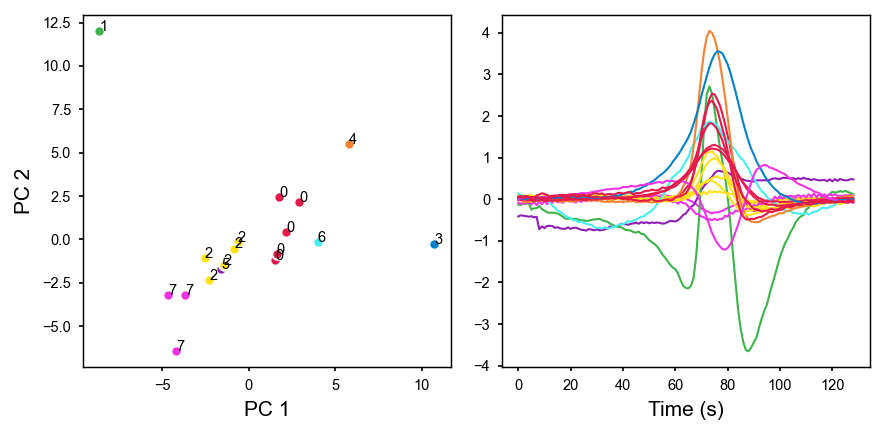

In [45]:
pca_i_mb = sklearn.decomposition.PCA(n_components=4) # <= N_i
X_i_mb = np.nanmean(ex.i_a['mb_baseline0_cen_i'], (1, 2, 3))
X_i_mb_tr = pca_i_mb.fit_transform(X_i_mb)
#X_i_mb_tr.shape

N_i_mb_cluster = 8
kmeans_i_mb = sklearn.cluster.KMeans(n_clusters=N_i_mb_cluster, init='k-means++', random_state=0).fit(X_i_mb_tr)

fig = plt.figure(figsize=(6, 3))
ax = plt.subplot(1, 2, 1)
for i in range(N_i):
    ax.plot(X_i_mb_tr[i, 0], X_i_mb_tr[i, 1], color=c_idx[kmeans_i_mb.labels_[i]], marker='.', 
            markersize=10, markeredgecolor='white')
    ax.text(X_i_mb_tr[i, 0]+0.02*np.random.rand(1), X_i_mb_tr[i, 1]+0.02*np.random.rand(1), kmeans_i_mb.labels_[i], size=7)
ax.set_xlabel('PC 1')  
ax.set_ylabel('PC 2')
ax = plt.subplot(1, 2, 2)    
for i in range(N_i):
    ax.plot(X_i_mb[i], color=c_idx[kmeans_i_mb.labels_[i]])
ax.set_xlabel('Time (s)')  
plt.tight_layout()
#plt.savefig('fig7.png', dpi=300)

In [46]:
i_mb_classify_idx = np.hstack([np.repeat(kmeans_i_mb.labels_[i], df[df['exp_id'] == i]['g_cell_num'].iloc[0]) for i in range(N_i)])
df = df.assign(i_mb_classify_idx=i_mb_classify_idx)

## 3. Save

In [47]:
pickle.dump(ex, open(proj_dir + 'data-figure/' + 'ex_210214.p', 'wb'))
pickle.dump(df, open(proj_dir + 'data-figure/' + 'df_210214.p', 'wb'))

<ipython-input-323-8ea2998ac535>:11: RuntimeWarning: Mean of empty slice
  ax.plot(np.nanmean(np.nanmean(np.stack([sub1, sub2]), 0)[:, :], 1))


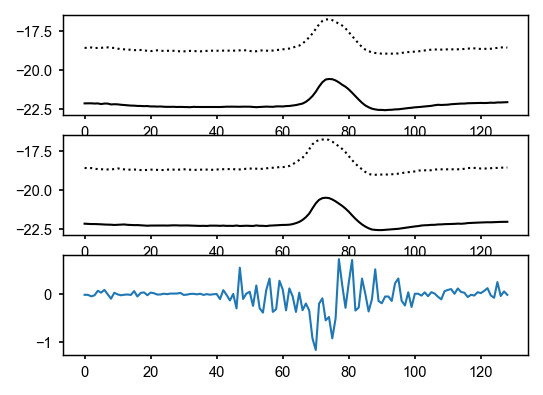

In [323]:
fig = plt.figure(figsize=(4, 3))
ax = plt.subplot(3, 1, 1)
ax.plot(np.nanmean(i_mb_ao_cen_i[:, 0, :, :]*4-18.5, axis=(0, 1)), 'k:') # l->r
ax.plot(np.nanmean(i_mb_cen_i[:, 0, :, :], axis=(0, 1)), 'k')
ax = plt.subplot(3, 1, 2)
ax.plot(np.nanmean(i_mb_cen_i[:, 1, :, :], axis=(0, 1)), 'k')            # r->l
ax.plot(np.nanmean(i_mb_ao_cen_i[:, 1, :, :]*4-18.5, axis=(0, 1)), 'k:')
ax = plt.subplot(3, 1, 3)
sub1 = g_mb_1_st_cen_i[0, 1, :, :] - g_mb_1_st_cen_i[0, 2, :, :]
sub2 = (g_mb_1_st_cen_i[1, 1, :, :] - g_mb_1_st_cen_i[1, 2, :, :])[:, ::-1]
ax.plot(np.nanmean(np.nanmean(np.stack([sub1, sub2]), 0)[:, :], 1))

In [ ]:
# G plot

In [ ]:
2d plot -> compare center of mass (of peak of inhibition vs peak of ganglion cell firing rate & stimuli)

In [ ]:
# I plot

In [ ]:
2d plot -> compare inhibition/membrane voltage peak & stimuli

In [241]:
zzz = np.vstack([[ex.g_a['mb_ad_cen_i'][g] for g in classify_idx_g], [ex.g_a['mb_da_cen_i'][g] for g in classify_idx_g]])
zzz.shape

(92, 2, 3, 32, 129)

In [254]:
zz = zzz[:, :, 1, :, :] - zzz[:, :, 2, :, :]
zz.shape

(92, 2, 32, 129)

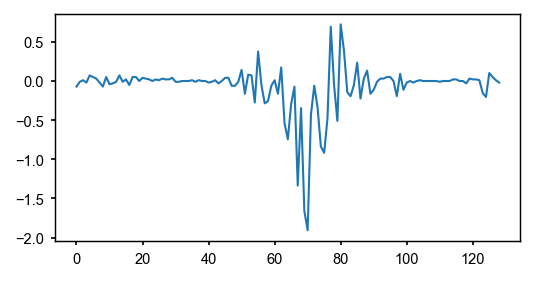

In [255]:
plt.plot(np.mean(zz, axis=(0, 1, 2))/(1/60))

In [361]:
class_l_con_g = np.concatenate([np.stack([np.roll(np.pad(utils.split_half_nan(ex.g[exp_idx_1][g][0, 0, :, :], 
                                                                              use_half_trial=df['use_half_con_trial'][g]), ((0, 0), (70, 70)), mode='constant'), 
                                                  int(np.round(df['cen_g_idx2'][g]/2)), axis=1)[:, 70:-70] 
                                          for g in classify_idx_g]),
                                np.stack([np.roll(np.pad(utils.split_half_nan(ex.g[exp_idx_2][g][0, 0, :, :], 
                                                                              use_half_trial=df['use_half_con_trial'][g]), ((0, 0), (70, 70)), mode='constant'), 
                                                  int(np.round(df['cen_g_idx2'][g]/2)), axis=1)[:, 70:-70] 
                                          for g in classify_idx_g])], axis=1)
class_l_amp_g = np.concatenate([np.stack([np.roll(np.pad(ex.g[exp_idx_1][g][0, 1, :, :], ((0, 0), (70, 70)), mode='constant'), 
                                                  int(np.round(df['cen_i_idx2'][g]/2)), axis=1)[:, 70:-70] 
                                          for g in classify_idx_g]),
                                np.stack([np.roll(np.pad(ex.g[exp_idx_2][g][0, 1, :, :], ((0, 0), (70, 70)), mode='constant'), 
                                                  int(np.round(df['cen_i_idx2'][g]/2)), axis=1)[:, 70:-70] 
                                          for g in classify_idx_g])], axis=1)
class_l_dim_g = np.concatenate([np.stack([np.roll(np.pad(ex.g[exp_idx_1][g][0, 2, :, :], ((0, 0), (70, 70)), mode='constant'), 
                                                  int(np.round(df['cen_i_idx2'][g]/2)), axis=1)[:, 70:-70] 
                                          for g in classify_idx_g]),
                                np.stack([np.roll(np.pad(ex.g[exp_idx_2][g][0, 2, :, :], ((0, 0), (70, 70)), mode='constant'), 
                                                  int(np.round(df['cen_i_idx2'][g]/2)), axis=1)[:, 70:-70] 
                                          for g in classify_idx_g])], axis=1)
class_r_con_g = np.concatenate([np.stack([np.roll(np.pad(utils.split_half_nan(ex.g[exp_idx_1][g][1, 0, :, :], 
                                                                              use_half_trial=df['use_half_con_trial'][g]), ((0, 0), (70, 70)), mode='constant'), 
                                                  int(np.round(-df['cen_g_idx2'][g]/2)), axis=1)[:, 70:-70] 
                                          for g in classify_idx_g]),
                                np.stack([np.roll(np.pad(utils.split_half_nan(ex.g[exp_idx_2][g][1, 0, :, :], 
                                                                              use_half_trial=df['use_half_con_trial'][g]), ((0, 0), (70, 70)), mode='constant'), 
                                                  int(np.round(-df['cen_g_idx2'][g]/2)), axis=1)[:, 70:-70] 
                                          for g in classify_idx_g])], axis=1)
class_r_amp_g = np.concatenate([np.stack([np.roll(np.pad(ex.g[exp_idx_1][g][1, 1, :, :], ((0, 0), (70, 70)), mode='constant'), 
                                                  int(np.round(-df['cen_i_idx2'][g]/2)), axis=1)[:, 70:-70] 
                                          for g in classify_idx_g]),
                                np.stack([np.roll(np.pad(ex.g[exp_idx_2][g][1, 1, :, :], ((0, 0), (70, 70)), mode='constant'), 
                                                  int(np.round(-df['cen_i_idx2'][g]/2)), axis=1)[:, 70:-70] 
                                          for g in classify_idx_g])], axis=1)
class_r_dim_g = np.concatenate([np.stack([np.roll(np.pad(ex.g[exp_idx_1][g][1, 2, :, :], ((0, 0), (70, 70)), mode='constant'), 
                                                  int(np.round(-df['cen_i_idx2'][g]/2)), axis=1)[:, 70:-70] 
                                          for g in classify_idx_g]),
                                np.stack([np.roll(np.pad(ex.g[exp_idx_2][g][1, 2, :, :], ((0, 0), (70, 70)), mode='constant'), 
                                                  int(np.round(-df['cen_i_idx2'][g]/2)), axis=1)[:, 70:-70] 
                                          for g in classify_idx_g])], axis=1)

In [362]:
class_con_g = np.concatenate([class_l_con_g, class_r_con_g], axis=0)[:, :, :]
class_amp_g = np.concatenate([class_l_amp_g, class_r_amp_g], axis=0)[:, :, :]
class_dim_g = np.concatenate([class_l_dim_g, class_r_dim_g], axis=0)[:, :, :]

class_tbins_g = ex.tbins['mb_ad'][0]
class_tbins_g_z = class_tbins_g-class_tbins_g[64]

#class_con_g_fr = np.stack([np.stack([spk.estfr(class_con_g[c, trial, :], class_tbins_g, sigma=0.01) 
#                                     for trial in range(class_con_g.shape[1])]) 
#                           for c in range(class_con_g.shape[0])])
class_con_g_fr = np.stack([np.stack([(class_con_g[c, trial, :] / ex.tbins['mb_ad'][0][1])
                                     for trial in range(class_con_g.shape[1])]) 
                           for c in range(class_con_g.shape[0])])
#class_amp_g_fr = np.stack([np.stack([spk.estfr(class_amp_g[c, trial, :], class_tbins_g, sigma=0.01) 
#                                     for trial in range(class_amp_g.shape[1])]) 
#                           for c in range(class_amp_g.shape[0])])
class_amp_g_fr = np.stack([np.stack([(class_amp_g[c, trial, :] / ex.tbins['mb_ad'][0][1])
                                     for trial in range(class_amp_g.shape[1])]) 
                           for c in range(class_amp_g.shape[0])])
#class_dim_g_fr = np.stack([np.stack([spk.estfr(class_dim_g[c, trial, :], class_tbins_g, sigma=0.01) 
#                                     for trial in range(class_dim_g.shape[1])]) 
#                           for c in range(class_dim_g.shape[0])])
class_dim_g_fr = np.stack([np.stack([(class_dim_g[c, trial, :] / ex.tbins['mb_ad'][0][1])
                                     for trial in range(class_dim_g.shape[1])]) 
                           for c in range(class_dim_g.shape[0])])

class_con_g_mean = np.nanmean(np.nanmean(class_con_g_fr, axis=1), axis=0)
class_amp_g_mean = np.nanmean(np.nanmean(class_amp_g_fr, axis=1), axis=0)
class_dim_g_mean = np.nanmean(np.nanmean(class_dim_g_fr, axis=1), axis=0)

class_con_g_sem = np.nanstd(np.nanmean(class_con_g_fr, axis=1), axis=0) / np.sqrt(class_con_g_fr.shape[0])
class_amp_g_sem = np.nanstd(np.nanmean(class_amp_g_fr, axis=1), axis=0) / np.sqrt(class_amp_g_fr.shape[0])
class_dim_g_sem = np.nanstd(np.nanmean(class_dim_g_fr, axis=1), axis=0) / np.sqrt(class_dim_g_fr.shape[0])

class_a_d_g_mean = np.nanmean(np.nanmean(class_amp_g_fr-class_dim_g_fr, axis=1), axis=0)
class_a_d_g_sem = np.nanstd(np.nanmean(class_amp_g_fr-class_dim_g_fr, axis=1), axis=0) / np.sqrt(class_amp_g_fr.shape[0])

In [363]:
class_amp_g_fr.shape

(92, 64, 129)

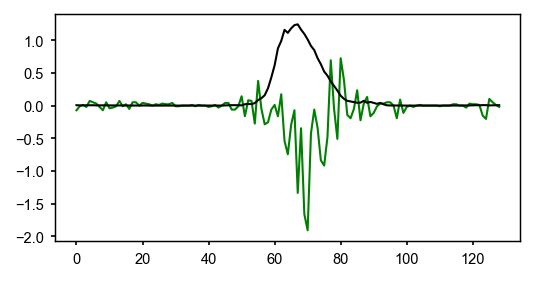

In [365]:
#plt.plot(np.nanmean(class_amp_g_fr - class_con_g_fr, axis=(0, 1)), 'r')
#plt.plot(np.nanmean(class_dim_g_fr - class_con_g_fr, axis=(0, 1)), 'b')
plt.plot(np.nanmean(class_amp_g_fr[:, : :] - class_dim_g_fr[:, :, :], axis=(0, 1)), 'g')
plt.plot(np.nanmean(np.nanmean(class_con_g_fr, axis=1), axis=0)/30, 'k')

In [312]:
import scipy.ndimage

In [313]:
np.nanmean(class_con_g, axis=1).shape

(174, 129)

In [314]:
com_con = np.array(list(scipy.ndimage.center_of_mass(np.nanmean(class_con_g, axis=1)[t, :])[0] for t in range(156)))
com_amp = np.array(list(scipy.ndimage.center_of_mass(np.nanmean(class_amp_g, axis=1)[t, :])[0] for t in range(156)))
com_dim = np.array(list(scipy.ndimage.center_of_mass(np.nanmean(class_dim_g, axis=1)[t, :])[0] for t in range(156)))
com_diff = np.array(list(scipy.ndimage.center_of_mass(np.nanmean(class_amp_g-class_con_g, axis=1)[t, :])[0] for t in range(156)))

/home/dlee/moving-bar/venv/lib/python3.8/site-packages/scipy/ndimage/measurements.py:1385: RuntimeWarning: invalid value encountered in double_scalars
  results = [sum(input * grids[dir].astype(float), labels, index) / normalizer
/home/dlee/moving-bar/venv/lib/python3.8/site-packages/scipy/ndimage/measurements.py:1385: RuntimeWarning: divide by zero encountered in double_scalars
  results = [sum(input * grids[dir].astype(float), labels, index) / normalizer


(30.0, 100.0)

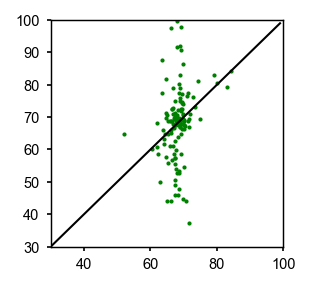

In [315]:
fig = plt.figure(figsize=(2, 2))
ax = plt.subplot(111)
ax.plot(com_con, com_diff, 'g.')
ax.plot(np.arange(100), 'k')
ax.set_xlim([30, 100])
ax.set_ylim([30, 100])

In [316]:
scipy.ndimage.center_of_mass(np.nanmean(class_con_g, axis=1), )

(86.11754403568465, 67.91558648872997)

In [317]:
np.argmax(np.nanmean(class_amp_g - class_dim_g, axis=1), axis=1)

array([ 78,  72,  63,  75,  63,  66,  75,  70,  63,  63,  61,  62,  63,
        60,  54,  77,  51,  66,  62,  64,  77,  72,  71,  72,  64,  73,
        71,  69,  86,  50,  64,  69,  66,  63,  70,  64,  74,  68,  67,
        71,  62,  74,  65,  65,  74,  70,  62,  68,  65,  66,  64,  72,
       121,  62,  67,  62,  72,  70,  60,  66,  70,  74,  69,  62,  66,
        70,  70,  66,  69,  66,  65,  66,  75,  70,  68,  69,  71,  63,
        68,  73,  70,  66,  63,  55,  62,  66,  61,  69,  63,  82,  77,
        65,  92,  70,  75,  60,  65,  68,  69,  87,   0,  70,  60,  65,
        63,  58,  60,  60,  69,  73,  70,  60,  67,  81,  61,  60,  64,
        60,  66,  62,  65,  68,  65,  70,  69,  79,  75,  76,  69,  66,
        69,  78,  73,  64,  60,  67,  69,  73,  64, 126,  67,  67,  67,
        74,  73,  61,  67,  69,  66,  69,  76,  68,  66,  83,  70,  73,
        67,  71,  60,  62,  67,  66,  68,  71,  61,  77,  67,  74,  66,
        63,  58,  65,  75,  59])

In [318]:
np.argmax(np.nanmean(class_con_g, axis=1), axis=1)

array([62, 71, 58, 58, 63, 59,  0, 61, 60, 64, 67, 62, 62, 67, 72, 67, 50,
       62, 59, 62, 66, 72, 61, 64, 63, 69, 61, 61, 59, 64, 70, 64, 62, 64,
       68, 70, 67, 68, 68, 68, 63, 69, 67, 70, 73, 69, 59, 64, 62, 64, 60,
       68, 58, 73, 62, 72, 70, 68, 59, 68, 68, 71, 59, 68, 60, 67, 62, 70,
       61, 64, 67, 64, 75, 67, 62, 70, 61, 64, 68, 67, 67, 68, 68, 67, 60,
       65, 68, 59, 62, 62, 61, 65,  0, 71, 62, 61, 65, 58, 59, 60,  0, 68,
       61, 63, 55, 59, 60, 60, 67, 60, 63, 60, 65, 57, 63, 60, 62, 68, 68,
       66, 65, 62, 68, 69, 63, 79, 66, 62, 60, 65, 63, 82, 67, 63, 65, 60,
        1, 57, 61, 58, 65, 64, 66, 67, 68, 66, 68, 66, 66, 61, 64, 56, 66,
       62, 71, 63, 62, 72, 60, 57, 62, 63, 68, 63, 62, 63, 63, 67, 65, 61,
       69, 60, 63, 59])

(40.0, 80.0)

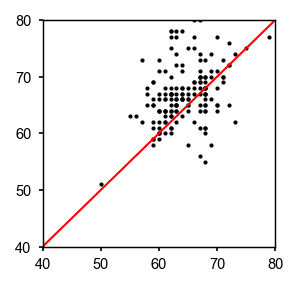

In [319]:
fig = plt.figure(figsize=(2, 2))
ax = plt.subplot(111)
ax.plot(np.argmax(np.nanmean(class_con_g, axis=1), axis=1), np.argmax(abs(np.nanmean(class_amp_g - class_dim_g, axis=1)), axis=1), 'k.')
ax.plot(np.arange(100), 'r')
ax.set_xlim([40, 80])
ax.set_ylim([40, 80])

(30.0, 100.0)

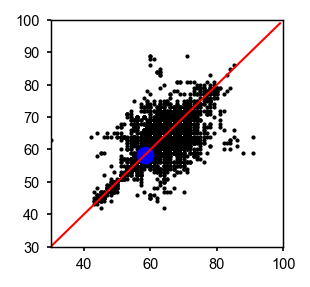

In [320]:
fig = plt.figure(figsize=(2, 2))
ax = plt.subplot(111)
ax.plot(np.argmax(class_amp_g, axis=2).ravel(), np.argmax(class_dim_g, axis=2).ravel(), 'k.')
ax.plot(np.mean(np.argmax(class_amp_g, axis=2).ravel()), np.mean(np.argmax(class_dim_g, axis=2).ravel()), 'b.', markersize=15)
ax.plot(np.arange(100), 'r')
ax.set_xlim([30, 100])
ax.set_ylim([30, 100])

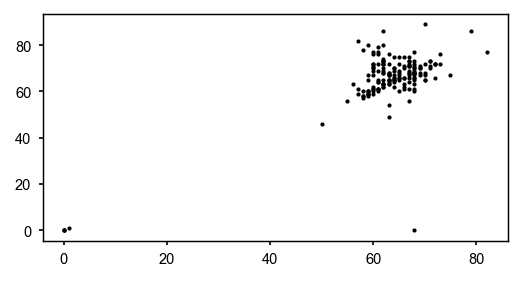

In [321]:
plt.plot(np.argmax(np.nanmean(class_con_g, axis=1), axis=1), np.argmin(np.nanmean(class_amp_g - class_con_g, axis=1), axis=1), 'k.')

In [236]:
class_l_con_raw_g = np.concatenate([np.stack([utils.split_half_nan(ex.g[exp_idx_1][g][0, 0, :, :], df['use_half_con_trial'][g]) for g in classify_idx_g]),
                                    np.stack([utils.split_half_nan(ex.g[exp_idx_2][g][0, 0, :, :], df['use_half_con_trial'][g]) for g in classify_idx_g])], axis=1)
class_l_amp_raw_g = np.concatenate([np.stack([ex.g[exp_idx_1][g][0, 1, :, :] for g in classify_idx_g]),
                                    np.stack([ex.g[exp_idx_2][g][0, 1, :, :] for g in classify_idx_g])], axis=1)
class_l_dim_raw_g = np.concatenate([np.stack([ex.g[exp_idx_1][g][0, 2, :, :] for g in classify_idx_g]),
                                    np.stack([ex.g[exp_idx_2][g][0, 2, :, :] for g in classify_idx_g])], axis=1)
class_r_con_raw_g = np.concatenate([np.stack([utils.split_half_nan(ex.g[exp_idx_1][g][1, 0, :, :], df['use_half_con_trial'][g]) for g in classify_idx_g]),
                                    np.stack([utils.split_half_nan(ex.g[exp_idx_2][g][1, 0, :, :], df['use_half_con_trial'][g]) for g in classify_idx_g])], axis=1)
class_r_amp_raw_g = np.concatenate([np.stack([ex.g[exp_idx_1][g][1, 1, :, :] for g in classify_idx_g]),
                                    np.stack([ex.g[exp_idx_2][g][1, 1, :, :] for g in classify_idx_g])], axis=1)
class_r_dim_raw_g = np.concatenate([np.stack([ex.g[exp_idx_1][g][1, 2, :, :] for g in classify_idx_g]),
                                    np.stack([ex.g[exp_idx_2][g][1, 2, :, :] for g in classify_idx_g])], axis=1)

In [237]:
class_l_con_g_st = [[] for i in range(128)]
class_l_amp_g_st = [[] for i in range(128)]
class_l_dim_g_st = [[] for i in range(128)]
class_r_con_g_st = [[] for i in range(128)]
class_r_amp_g_st = [[] for i in range(128)]
class_r_dim_g_st = [[] for i in range(128)]
for i, g in enumerate(classify_idx_g):
    idx_space = int(np.round(63.5 - df['i_g_idx2'][g]/2))
    #class_l_con_g_st[idx_space].append(np.stack([spk.estfr(class_l_con_raw_g[i, trial, :], class_tbins_g, sigma=0.01) 
    #                                           for trial in range(class_l_con_raw_g[i, :, :].shape[0])]))
    #class_l_amp_g_st[idx_space].append(np.stack([spk.estfr(class_l_amp_raw_g[i, trial, :], class_tbins_g, sigma=0.01) 
    #                                           for trial in range(class_l_amp_raw_g[i, :, :].shape[0])]))
    #class_l_dim_g_st[idx_space].append(np.stack([spk.estfr(class_l_dim_raw_g[i, trial, :], class_tbins_g, sigma=0.01) 
    #                                           for trial in range(class_l_dim_raw_g[i, :, :].shape[0])]))
    #class_r_con_g_st[idx_space].append(np.stack([spk.estfr(class_r_con_raw_g[i, trial, :], class_tbins_g, sigma=0.01) 
    #                                           for trial in range(class_r_con_raw_g[i, :, :].shape[0])]))
    #class_r_amp_g_st[idx_space].append(np.stack([spk.estfr(class_r_amp_raw_g[i, trial, :], class_tbins_g, sigma=0.01) 
    #                                           for trial in range(class_r_amp_raw_g[i, :, :].shape[0])]))
    #class_r_dim_g_st[idx_space].append(np.stack([spk.estfr(class_r_dim_raw_g[i, trial, :], class_tbins_g, sigma=0.01) 
    #                                           for trial in range(class_r_dim_raw_g[i, :, :].shape[0])]))
    class_l_con_g_st[idx_space].append(np.stack([(class_l_con_raw_g[i, trial, :] / ex.tbins['mb_ad'][0][1])
                                               for trial in range(class_l_con_raw_g[i, :, :].shape[0])]))
    class_l_amp_g_st[idx_space].append(np.stack([(class_l_amp_raw_g[i, trial, :] / ex.tbins['mb_ad'][0][1])
                                               for trial in range(class_l_amp_raw_g[i, :, :].shape[0])]))
    class_l_dim_g_st[idx_space].append(np.stack([(class_l_dim_raw_g[i, trial, :] / ex.tbins['mb_ad'][0][1])
                                               for trial in range(class_l_dim_raw_g[i, :, :].shape[0])]))
    class_r_con_g_st[idx_space].append(np.stack([(class_r_con_raw_g[i, trial, :] / ex.tbins['mb_ad'][0][1])
                                               for trial in range(class_r_con_raw_g[i, :, :].shape[0])]))
    class_r_amp_g_st[idx_space].append(np.stack([(class_r_amp_raw_g[i, trial, :] / ex.tbins['mb_ad'][0][1])
                                               for trial in range(class_r_amp_raw_g[i, :, :].shape[0])]))
    class_r_dim_g_st[idx_space].append(np.stack([(class_r_dim_raw_g[i, trial, :] / ex.tbins['mb_ad'][0][1])
                                               for trial in range(class_r_dim_raw_g[i, :, :].shape[0])]))

In [238]:
class_l_con_g_mean_st = np.zeros((129, 128))
class_l_amp_g_mean_st = np.zeros((129, 128))
class_l_dim_g_mean_st = np.zeros((129, 128))
class_r_con_g_mean_st = np.zeros((129, 128))
class_r_amp_g_mean_st = np.zeros((129, 128))
class_r_dim_g_mean_st = np.zeros((129, 128))
for i in range(class_l_con_g_mean_st.shape[1]):
    if len(class_l_con_g_st[i]) > 0:
        class_l_con_g_mean_st[:, i] = np.nanmean(np.nanmean(np.stack(class_l_con_g_st[i]), axis=1), axis=0)
        class_l_amp_g_mean_st[:, i] = np.nanmean(np.nanmean(np.stack(class_l_amp_g_st[i]), axis=1), axis=0)
        class_l_dim_g_mean_st[:, i] = np.nanmean(np.nanmean(np.stack(class_l_dim_g_st[i]), axis=1), axis=0)
        class_r_con_g_mean_st[:, i] = np.nanmean(np.nanmean(np.stack(class_r_con_g_st[i]), axis=1), axis=0)
        class_r_amp_g_mean_st[:, i] = np.nanmean(np.nanmean(np.stack(class_r_amp_g_st[i]), axis=1), axis=0)
        class_r_dim_g_mean_st[:, i] = np.nanmean(np.nanmean(np.stack(class_r_dim_g_st[i]), axis=1), axis=0)

In [239]:
class_con_g_mean_st = (class_l_con_g_mean_st + class_r_con_g_mean_st[:, ::-1])/2
class_l_a_d_g_mean_st = class_l_amp_g_mean_st - class_l_dim_g_mean_st
class_r_a_d_g_mean_st = class_r_amp_g_mean_st - class_r_dim_g_mean_st
class_a_d_g_mean_st = (class_l_a_d_g_mean_st + class_r_a_d_g_mean_st[:, ::-1])/2

In [240]:
class_l_stim_st = st.downsample(ext.load_stimulus_mb().T, 2)[0].T

In [241]:
#

In [242]:
class_l_i = np.stack([np.stack([scipy.signal.resample(st.downsample(np.roll(np.pad(ex.i['mb'][i][0, :, :-5], 
                                                                                   ((0, 0), (12000, 12000)), mode='edge'), 
                                                                            int((10000/60) * df[(df['exp_id'] == i)]['cen_i_idx2'].unique()/2), 
                                                                            axis=1)[trial, 12000:-12000], 10)[0], 129) 
                                for trial in range(20)]) for i in classify_idx_i])
class_r_i = np.stack([np.stack([scipy.signal.resample(st.downsample(np.roll(np.pad(ex.i['mb'][i][1, :, :-5], 
                                                                                   ((0, 0), (12000, 12000)), mode='edge'), 
                                                                            int((10000/60) * -df[(df['exp_id'] == i)]['cen_i_idx2'].unique()/2), 
                                                                            axis=1)[trial, 12000:-12000], 10)[0], 129) 
                                for trial in range(20)]) for i in classify_idx_i])
class_l_ao = np.stack([np.stack([scipy.signal.resample(st.downsample(np.roll(np.pad(ex.i['mb_ad_ao'][i][0, 1, :4, :-5], 
                                                                                    ((0, 0), (12000, 12000)), mode='edge'), 
                                                                             int((10000/60) * df[(df['exp_id'] == i)]['cen_i_idx2'].unique()/2), 
                                                                             axis=1)[trial, 12000:-12000], 10)[0], 129) 
                                 for trial in range(4)]) for i in classify_idx_i])
class_r_ao = np.stack([np.stack([scipy.signal.resample(st.downsample(np.roll(np.pad(ex.i['mb_ad_ao'][i][1, 1, :4, :-5], 
                                                                                    ((0, 0), (12000, 12000)), mode='edge'), 
                                                                             int((10000/60) * -df[(df['exp_id'] == i)]['cen_i_idx2'].unique()/2), 
                                                                             axis=1)[trial, 12000:-12000], 10)[0], 129) 
                                 for trial in range(4)]) for i in classify_idx_i])

In [243]:
class_i = np.concatenate([class_l_i, class_r_i], axis=0)
class_ao = np.concatenate([class_l_ao, class_r_ao], axis=0)

class_tbins_i = class_tbins_g
class_tbins_i_z = class_tbins_i-class_tbins_i[64]

class_l_i_mean = np.nanmean(np.nanmean(class_l_i, axis=1), axis=0)
class_r_i_mean = np.nanmean(np.nanmean(class_r_i, axis=1), axis=0)
class_i_mean = np.nanmean(np.nanmean(class_i, axis=1), axis=0)
class_l_ao_mean = np.nanmean(np.nanmean(class_l_ao, axis=1), axis=0)
class_r_ao_mean = np.nanmean(np.nanmean(class_r_ao, axis=1), axis=0)
class_ao_mean = np.nanmean(np.nanmean(class_ao, axis=1), axis=0)

class_i_sem = np.nanstd(np.nanmean(class_i - np.mean(class_i, axis=(1, 2))[:, np.newaxis, np.newaxis], axis=1), 
                        axis=0) / np.sqrt(class_i.shape[0])

### 3-04. Average firing rate of ganglion (temporally aligned at rf center)

(-1.0666666666666667, 1.0666666666666667)

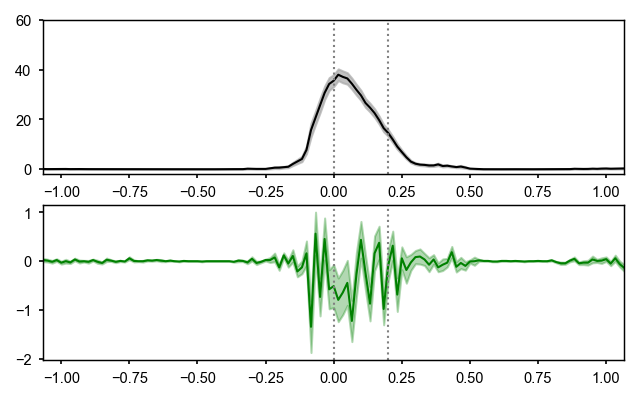

In [244]:
fig = plt.figure(figsize=(5, 3))
ax = plt.subplot(211)
ax.fill_between(class_tbins_g_z, 
                class_con_g_mean - class_con_g_sem, 
                class_con_g_mean + class_con_g_sem, color='darkgray', alpha=0.7)
ax.plot(class_tbins_g_z, class_con_g_mean, 'k-', linewidth=1)
ax.axvline(x=class_tbins_g_z[64], color='gray', linestyle=':')
ax.axvline(x=class_tbins_g_z[76], color='gray', linestyle=':')
ax.set_xlim([class_tbins_g_z[0], class_tbins_g_z[-1]])
ax.set_ylim([-2, 60])
ax = plt.subplot(212)
ax.fill_between(class_tbins_g_z, 
                class_a_d_g_mean - class_a_d_g_sem, 
                class_a_d_g_mean + class_a_d_g_sem, color='green', alpha=0.3)
ax.plot(class_tbins_g_z, class_a_d_g_mean, 'g-', linewidth=1)
ax.axvline(x=class_tbins_g_z[64], color='gray', linestyle=':')
ax.axvline(x=class_tbins_g_z[76], color='gray', linestyle=':')
ax.set_xlim([class_tbins_g_z[0], class_tbins_g_z[-1]])
#fig.savefig('ganglion.pdf', format='pdf', bbox_inches='tight', transparent=True)

### 3-05. Average membrane voltage fluctuation of intracell (temporally aligned at rf center)

(0.0, 2.1333333333333333)

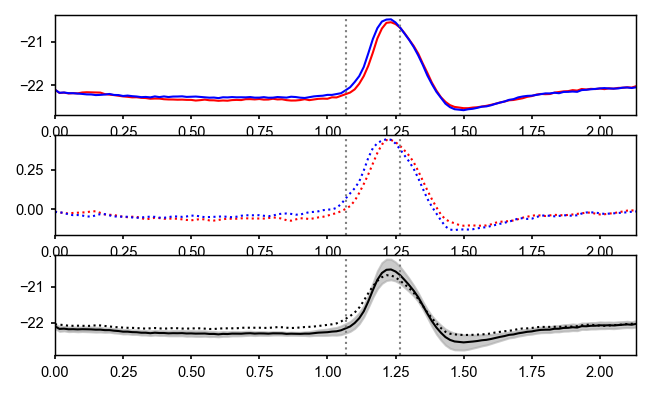

In [245]:
fig = plt.figure(figsize=(5, 3))
ax = plt.subplot(311)
ax.plot(class_tbins_i, class_l_i_mean, 'r-', linewidth=1)
ax.plot(class_tbins_i, class_r_i_mean, 'b-', linewidth=1)
ax.axvline(x=class_tbins_i[64], color='gray', linestyle=':')
ax.axvline(x=class_tbins_i[76], color='gray', linestyle=':')
ax.set_xlim([class_tbins_i[0], class_tbins_i[-1]])
ax = plt.subplot(312)
ax.plot(class_tbins_i, class_l_ao_mean, 'r:', linewidth=1)
ax.plot(class_tbins_i, class_r_ao_mean, 'b:', linewidth=1)
ax.axvline(x=class_tbins_i[64], color='gray', linestyle=':')
ax.axvline(x=class_tbins_i[76], color='gray', linestyle=':')
ax.set_xlim([class_tbins_i[0], class_tbins_i[-1]])
ax = plt.subplot(313)
ax.plot(class_tbins_i, class_i_mean, 'k-', linewidth=1)
ax.plot(class_tbins_i, class_ao_mean*3-22, 'k:', linewidth=1)
ax.fill_between(class_tbins_i, 
                class_i_mean - class_i_sem, 
                class_i_mean + class_i_sem, color='darkgray', alpha=0.6)
ax.axvline(x=class_tbins_i[64], color='gray', linestyle=':')
ax.axvline(x=class_tbins_i[76], color='gray', linestyle=':')
ax.set_xlim([class_tbins_i[0], class_tbins_i[-1]])
#ax.set_ylim([-3, 55])

### 3-06. Changed firing rate in space-time map

In [255]:
smooth_t, smooth_x = (2, 2)

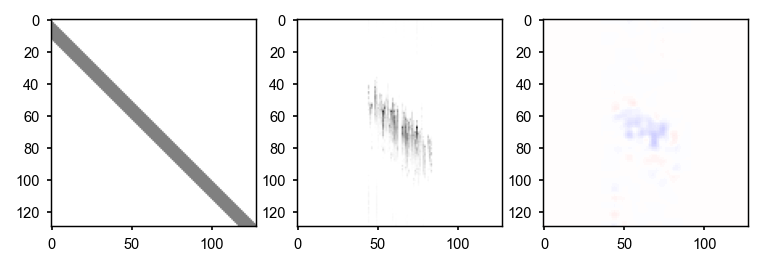

In [256]:
fig = plt.figure(figsize=(6, 2))
ax = plt.subplot(131)
ax.imshow(class_l_stim_st, cmap='gray', vmin=-1, vmax=0)
ax = plt.subplot(132)
ax.imshow(class_con_g_mean_st, cmap='gray_r', vmin=0, vmax=np.max(class_con_g_mean_st))
ax = plt.subplot(133)
ax.imshow(scipy.ndimage.gaussian_filter(class_a_d_g_mean_st, [smooth_t, smooth_x]), cmap='seismic', interpolation='nearest',
          vmin=-0.5*np.max(abs(class_a_d_g_mean_st)), vmax=0.5*np.max(abs(class_a_d_g_mean_st)))

### 3-07. Spatiotemporal transformation analysis

In [257]:
def transform_st(mat):
    mat_tr = np.stack([np.roll(np.pad(mat, ((0, 0), (70, 70)), mode='constant')[t, :], 
                               64-t)[70:-70] for t in range(mat.shape[0])])
    return mat_tr

In [258]:
class_num_g_st = np.sum(np.sum(class_con_g_mean_st, axis=0) > 0)

In [259]:
class_l_stim_st_tr = transform_st(class_l_stim_st)
class_con_g_mean_st_tr = transform_st(class_con_g_mean_st)
class_a_d_g_mean_st_tr = transform_st(class_a_d_g_mean_st)

In [260]:
class_l_stim_st_tr_space = np.nanmean(class_l_stim_st_tr[20:, :], axis=0)
class_con_g_mean_st_tr_space = np.sum(class_con_g_mean_st_tr, axis=0)/class_num_g_st
class_a_d_g_mean_st_tr_space = np.sum(scipy.ndimage.gaussian_filter(class_a_d_g_mean_st_tr, [smooth_t, smooth_x]), axis=0)/class_num_g_st

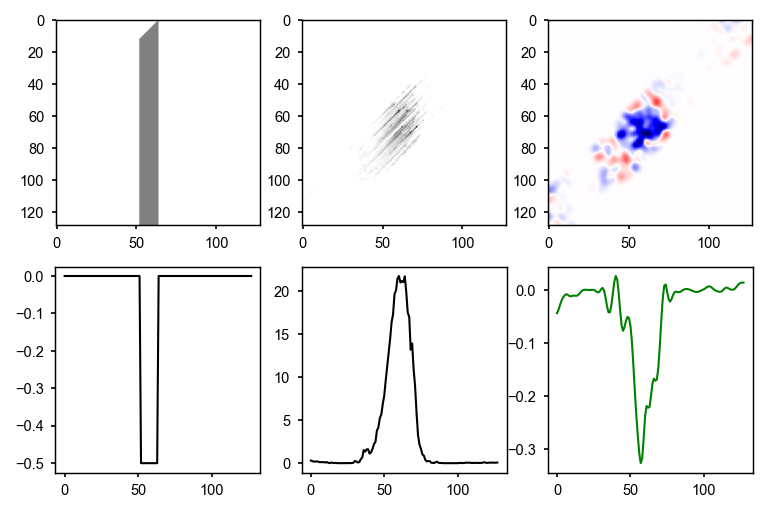

In [261]:
class_a_d_g_mean_st_tr_smooth = scipy.ndimage.gaussian_filter(class_a_d_g_mean_st_tr, [smooth_t, smooth_x])

fig = plt.figure(figsize=(6, 4))
ax = plt.subplot(231)
ax.imshow(class_l_stim_st_tr, cmap='gray', vmin=-1, vmax=0)
ax = plt.subplot(234)
ax.plot(class_l_stim_st_tr_space, 'k')
ax = plt.subplot(232)
ax.imshow(class_con_g_mean_st_tr, cmap='gray_r', vmin=0, vmax=np.nanmax(class_con_g_mean_st_tr))
ax = plt.subplot(235)
ax.plot(class_con_g_mean_st_tr_space, 'k')
ax = plt.subplot(233)
ax.imshow(class_a_d_g_mean_st_tr_smooth, cmap='seismic', 
          vmin=-np.nanmax(abs(class_a_d_g_mean_st_tr_smooth)), vmax=np.nanmax(abs(class_a_d_g_mean_st_tr_smooth)))
ax = plt.subplot(236)
ax.plot(class_a_d_g_mean_st_tr_space, 'g')

### 3-08. Model of changed intracell gain

In [262]:
intracell_gain_a = np.arange(2, 50, 4)
intracell_gain_d = np.arange(-2, -50, -4)

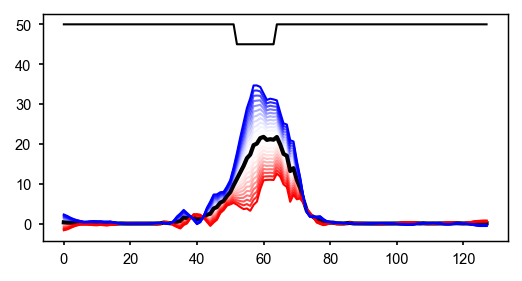

In [263]:
plt.plot(class_con_g_mean_st_tr_space, 'k', linewidth=2)
for g_a in intracell_gain_a:
    plt.plot(class_con_g_mean_st_tr_space + g_a * class_a_d_g_mean_st_tr_space, 'r', alpha=(g_a/np.max(intracell_gain_a))**2)
for g_d in intracell_gain_d:
    plt.plot(class_con_g_mean_st_tr_space + g_d * class_a_d_g_mean_st_tr_space, 'b', alpha=(g_d/np.min(intracell_gain_d))**2)
plt.plot(class_l_stim_st_tr_space*10+50, 'k')

# 4. Other analysis

### 4-01. without stimulus ('mb_ns')

In [188]:
classify2_idx_g = classify_02_idx_g
classify2_idx_i = classify_02_idx_i
exp_idx_3 = 'mb_ns'

In [189]:
ex.g['mb_ns'][0].shape

(2, 2, 4, 129)

In [190]:
class2_l_amp_g = np.stack([np.roll(np.pad(ex.g[exp_idx_3][g][0, 0, :, :], ((0, 0), (70, 70)), mode='constant'), 
                                   int(np.round(df['cen_g_idx2'][g]/2)), axis=1)[:, 70:-70] 
                           for g in classify2_idx_g])
class2_l_dim_g = np.stack([np.roll(np.pad(ex.g[exp_idx_3][g][0, 1, :, :], ((0, 0), (70, 70)), mode='constant'), 
                                   int(np.round(df['cen_g_idx2'][g]/2)), axis=1)[:, 70:-70] 
                           for g in classify2_idx_g])
class2_r_amp_g = np.stack([np.roll(np.pad(ex.g[exp_idx_3][g][1, 0, :, :], ((0, 0), (70, 70)), mode='constant'), 
                                   int(np.round(-df['cen_g_idx2'][g]/2)), axis=1)[:, 70:-70] 
                           for g in classify2_idx_g])
class2_r_dim_g = np.stack([np.roll(np.pad(ex.g[exp_idx_3][g][1, 1, :, :], ((0, 0), (70, 70)), mode='constant'), 
                                   int(np.round(-df['cen_g_idx2'][g]/2)), axis=1)[:, 70:-70] 
                           for g in classify2_idx_g])

In [214]:
class2_amp_g = np.concatenate([class2_l_amp_g, class2_r_amp_g], axis=0)[:, :, :]
class2_dim_g = np.concatenate([class2_l_dim_g, class2_r_dim_g], axis=0)[:, :, :]

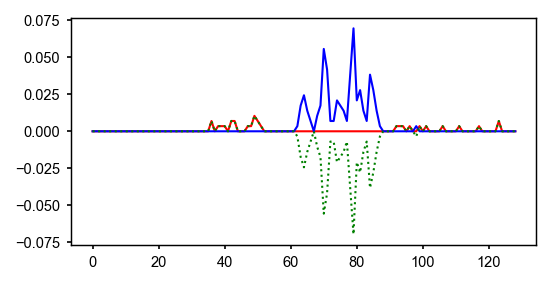

In [246]:
plt.plot(np.mean(np.mean(class2_amp_g, axis=1), axis=0), 'r')
plt.plot(np.mean(np.mean(class2_dim_g, axis=1), axis=0), 'b')
plt.plot(np.mean(np.mean(class2_amp_g, axis=1), axis=0) - np.mean(np.mean(class2_dim_g, axis=1), axis=0), 'g:')

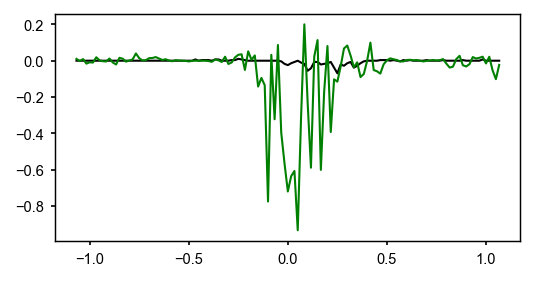

In [256]:
# without stim
plt.plot(class_tbins_g - class_tbins_g[64], 
         np.mean(np.mean(class2_amp_g, axis=1), axis=0) - np.mean(np.mean(class2_dim_g, axis=1), axis=0), 'k')
# with stim
plt.plot(class_tbins_g - class_tbins_g[64], class_a_d_g_mean, 'g')

# 5. Statistics

### 5-01. changed firing rate (One sample student's t-test)

In [74]:
import scipy.stats
t, p = scipy.stats.ttest_1samp(np.nanmean(class_amp_g_fr-class_dim_g_fr, axis=1), 0, axis=0)

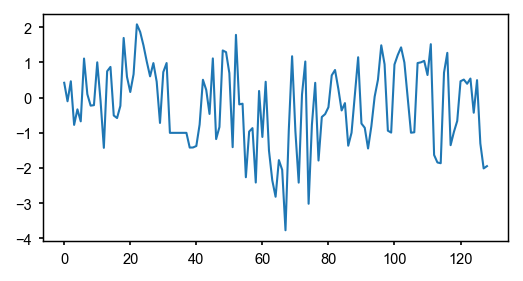

In [75]:
plt.plot(t)

In [76]:
p[p<0.01]

array([0.00546591, 0.00022951, 0.00297652])

## 

(0.0, 32.0)

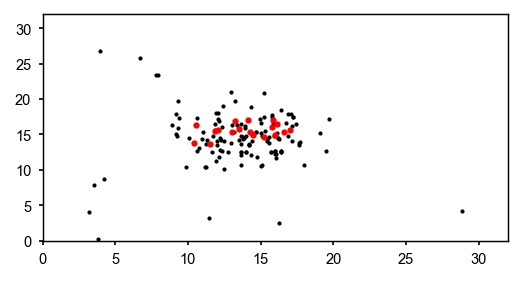

In [77]:
for i in range(134):
    plt.plot([ex.rf['g']['ellipse'][i][0]], [ex.rf['g']['ellipse'][i][1]], 'k.')
for i in range(18):
    plt.plot([ex.rf['i']['ellipse'][i][0]], [ex.rf['i']['ellipse'][i][1]], 'ro')
plt.xlim([0, 32])
plt.ylim([0, 32])

In [ ]:
df[(df['exp_id'] == 1) & (df['g_cell_id'] < 30)]

In [159]:
df[(df['exp_id'] == 1) | (df['g_cell_id'] < 30)]

In [46]:
'''
with h5py.File('/Users/dlee/mb/data-extract/17-10-18_extract.h5', 'r') as ff:
    for key in list(ff.keys()):
        print(key)
        for key2 in list(ff[key].keys()):
            print(' ', key2)
            #print('    ', ff[key][key2])
            for key3 in list(ff[key][key2].keys()):
                print('    ', key3)
                print('        ', ff[key][key2][key3].shape)
    z = np.double(ff['etc']['mb_ad_ao']['ganglion'])
'''

"\nwith h5py.File('/Users/dlee/mb/data-extract/17-10-18_extract.h5', 'r') as ff:\n    for key in list(ff.keys()):\n        print(key)\n        for key2 in list(ff[key].keys()):\n            print(' ', key2)\n            #print('    ', ff[key][key2])\n            for key3 in list(ff[key][key2].keys()):\n                print('    ', key3)\n                print('        ', ff[key][key2][key3].shape)\n    z = np.double(ff['etc']['mb_ad_ao']['ganglion'])\n"

In [319]:
kmeans_i.labels_

array([0, 2, 1, 1, 1, 1, 0, 1, 1, 1, 2, 1, 1, 1, 1, 0, 1, 1], dtype=int32)

In [996]:
ex.g['flash_1'][0].shape

(10, 122)

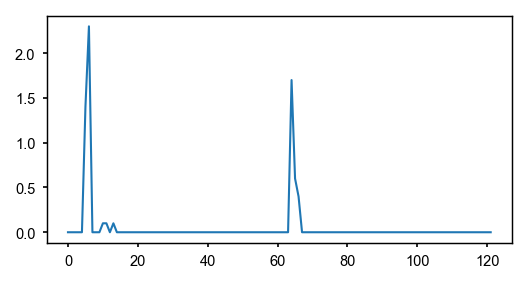

In [1196]:
plt.plot(np.nanmean(ex.g['flash_1'][10], axis=0))

In [1197]:
ex.i['mb_ad_ao'][0].shape

(2, 3, 32, 21500)

In [1245]:
plt.plot(np.mean(ex.i['flash_1'][18], axis=0))

IndexError: list index out of range

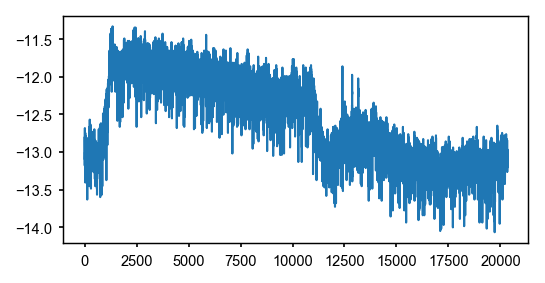

In [1242]:
plt.plot(ex.i['flash_1'][15][5])

In [63]:
plt.plot(ex.i['mb_ad'][0][0])

TypeError: 'float' object is not subscriptable

In [69]:
ex.i['mb'][0].shape

(2, 20, 21500)

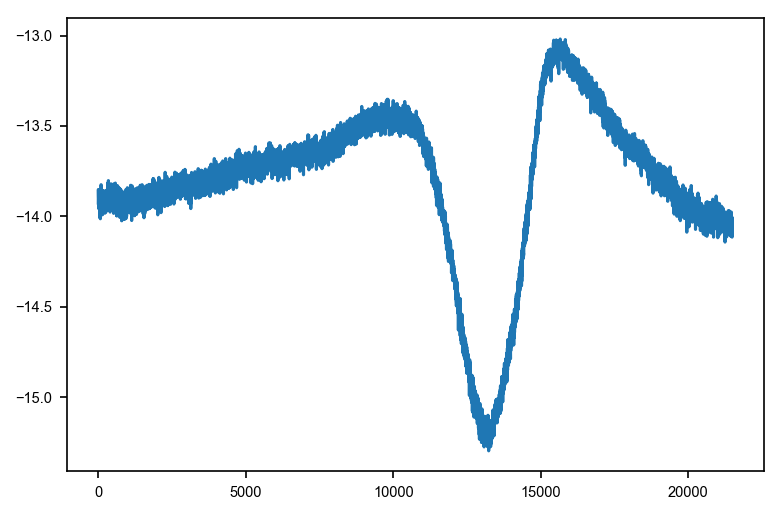

In [187]:
plt.plot(np.mean(ex.i['mb'][15][0], axis=0))

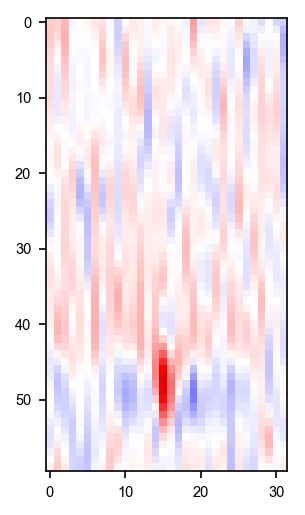

In [157]:
plt.imshow(np.mean(ex.rf['i']['st'][0], axis=1), cmap='seismic', vmin=-1000, vmax=1000)

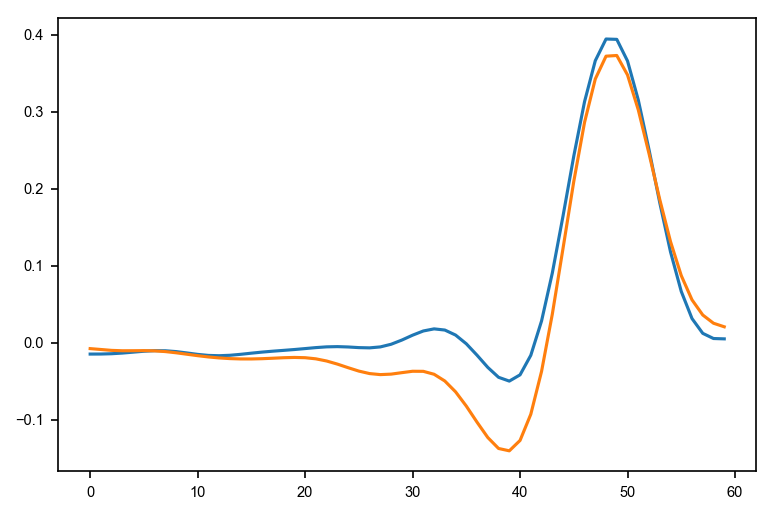

In [117]:
plt.plot(ex.rf['i']['time'][0])
plt.plot(ex.rf['i']['time'][6])
#plt.plot(ex.rf['i']['time'][15])

In [115]:
df[df['i_classify_idx'] == 1]

,data_dir,exp_id,exp_date,exp_name,exp_version,retina_idx,intracell_idx,g_cell_num,g_cell_id,flash_1,...,mb_th,flash_2_th,cen_g_idx1,cen_g_idx2,cen_i_idx1,cen_i_idx2,i_g_idx1,i_g_idx2,g_classify_idx,i_classify_idx
0,/Users/dlee/mb/data/,0,17-10-18,17-10-18,1,1,5,6,0,1,...,0.50,0.50,12.538971,-5.121479,9.725958,1.494850,2.813013,-6.616328,1,1
1,/Users/dlee/mb/data/,0,17-10-18,17-10-18,1,1,5,6,1,1,...,0.50,0.50,-11.053245,-19.367894,9.725958,1.494850,-20.779203,-20.862743,1,1
2,/Users/dlee/mb/data/,0,17-10-18,17-10-18,1,1,5,6,2,1,...,0.50,0.50,-33.430044,-14.041718,9.725958,1.494850,-43.156002,-15.536568,1,1
3,/Users/dlee/mb/data/,0,17-10-18,17-10-18,1,1,5,6,3,1,...,0.50,0.50,-11.041365,5.587749,9.725958,1.494850,-20.767324,4.092899,1,1
4,/Users/dlee/mb/data/,0,17-10-18,17-10-18,1,1,5,6,4,1,...,0.50,0.50,8.717430,12.071995,9.725958,1.494850,-1.008528,10.577145,1,1
5,/Users/dlee/mb/data/,0,17-10-18,17-10-18,1,1,5,6,5,1,...,0.50,0.50,9.151689,27.563600,9.725958,1.494850,-0.574270,26.068750,3,1
50,/Users/dlee/mb/data/,6,17-11-07,17-11-07,2,1,5,6,50,1,...,0.65,0.65,12.740057,-3.552016,-5.254025,-7.279946,17.994082,3.727930,1,1
51,/Users/dlee/mb/data/,6,17-11-07,17-11-07,2,1,5,6,51,1,...,0.65,0.65,25.504481,-4.858727,-5.254025,-7.279946,30.758506,2.421219,0,1
52,/Users/dlee/mb/data/,6,17-11-07,17-11-07,2,1,5,6,52,1,...,0.65,0.65,30.389386,5.642617,-5.254025,-7.279946,35.643411,12.922563,5,1
53,/Users/dlee/mb/data/,6,17-11-07,17-11-07,2,1,5,6,53,1,...,0.65,0.65,50.463051,-19.465832,-5.254025,-7.279946,55.717076,-12.185886,1,1


### 3-03. LN model of ganglion and intracell (temporally aligned at rf centor)

In [107]:
# This is computationally heavy
g=0
nbins=40
mb_ln_pred_lr = np.zeros((N_g, 129))
for g in tqdm.tqdm(range(1)):
    wn_filtered = ft.linear_response(ex.rf['g']['st'][g][::-1], ex.stim['rf_30m'][df['exp_id'][g]][10000:20000])
    binterp = nlt.Binterp(nbins=nbins, method='linear', fill_value='extrapolate')
    binterp.fit(wn_filtered, spk.estfr(ex.g['rf_30m'][g][10000:20000], ex.tbins['rf_30m'][df['exp_id'][g]][10000:20000], 0.01))
    #lin_pred = binterp.predict(wn_filtered)
    mb_filtered = ft.linear_response(np.repeat(np.repeat(ex.rf['g']['st'][g], 8, axis=1), 8, axis=2)[::-1], 
                                     np.repeat(np.repeat(ex.stim['mb'][df['exp_id'][g]][:, None, :], 256, axis=1), 2, axis=0))
    mb_nonlin = st.downsample(binterp.predict(mb_filtered), 2)[0]
    mb_ln_pred = np.roll(np.pad(mb_nonlin, (70, 70), mode='constant'), int(np.round(df['cen_g_idx2'][g]/2)), axis=0)[70:-70]
    mb_ln_pred_lr[g, :] = mb_ln_pred

100%|██████████| 1/1 [00:24<00:00, 24.36s/it]


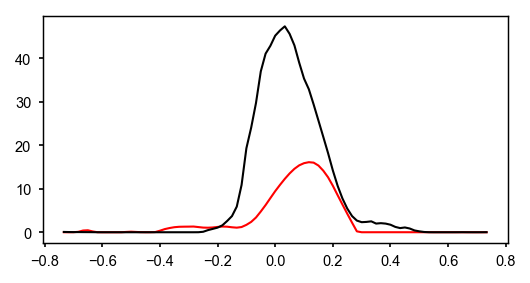

In [109]:
plt.plot(class_tbins[20:-20], np.nanmean(mb_ln_pred_lr, axis=0)[20:-20], 'r')
plt.plot(class_tbins[20:-20], np.nanmean(np.nanmean(class_con_g_fr, axis=1), axis=0)[20:-20], 'k')

In [110]:
mb_ln_pred_lr_i = np.zeros((classify_idx_i.shape[0], 129))
for n, i in tqdm.tqdm(enumerate(classify_idx_i)):
    mb_filtered_i = ft.linear_response(np.repeat(np.repeat(ex.rf['i']['st'][i], 8, axis=1), 8, axis=2)[::-1], 
                                       np.repeat(np.repeat(ex.stim['mb'][0][:, None, :], 256, axis=1), 2, axis=0)/5)
    mb_nonlin_i = st.downsample(mb_filtered_i, 2)[0]
    mb_ln_pred_i = np.roll(np.pad(mb_nonlin_i, (70, 70), mode='edge'), 
                           int(np.round(df[(df['exp_id'] == i)]['cen_i_idx2'].unique()/2)), axis=0)[70:-70]
    mb_ln_pred_lr_i[n, :] = mb_ln_pred_i

9it [02:10, 15.24s/it]


In [515]:
#plt.plot(mb_ln_pred_lr_i.T)

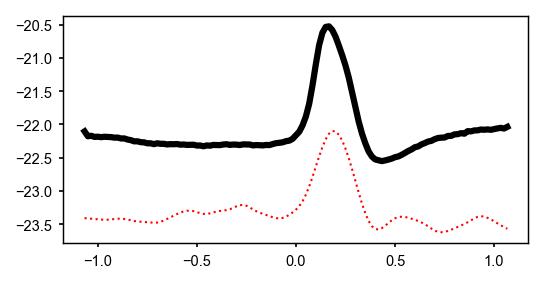

In [111]:
plt.plot(class_tbins, np.nanmean(np.nanmean(class_i, axis=1), axis=0), 'k-', linewidth=3)
plt.plot(class_tbins, np.nanmean(mb_ln_pred_lr_i, axis=0)/1601100 - 23.4, 'r:')

In [1541]:
plt.plot(np.mean(ex.g['mb_ns'][15], axis=(0, 1, 2)))

IndexError: tuple index out of range

In [1618]:
ex.g.keys()

dict_keys(['flash_1', 'rf_wn', 'mb_ns', 'mb_ad', 'mb_da', 'mb_2ad', 'mb_4ad', 'mb_2da', 'mb_4da', 'rf_30m', 'line', 'rf_5m', 'mb', 'flash_2', 'mb_ad_ao'])

In [1631]:
ex.i['rf_wn'][11].shape

(72000,)

In [1634]:
len(ex.g['rf_wn'])

134